# 데이터 분석

## 라이브러리

In [1]:
# %pip install --upgrade pip

In [2]:
# !pip install JPype1-1.3.0-cp39-cp39-win_amd64.whl
# !pip install konlpy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import sys

from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from collections import Counter

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from konlpy.tag import Hannanum
from konlpy.tag import Okt

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 그래프 한글폰트 출력을 위한 코드
def get_font_family():
    '''
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    '''
    import platform
    system_name = platform.system()
    # mac OS 일때
    if system_name == 'Darwin' :
        font_faimly = 'AppleGothic'
    # 윈도우일떄 
    elif system_name == 'Windows':
        font_family = 'Malgun Gothic'
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = 'NanumBarunGothic'

    return font_family

# style 설정은 꼭 폰트설정 위에서 한다. 
# style에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 깨진다.
# plt.style.use('seaborn')

#폰트설정
plt.rc('font', family=get_font_family())

#마이너스폰트 설정
plt.rc('axes', unicode_minus=False)

# 그래프에 retina display 적용
# 그래프 해상도 
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina'

# 기업리스트

## 데이터셋 불러오기

In [5]:
# 기업 리스트 csv 불러오기
df_company_list = pd.read_csv('./input/df_company_list.csv', index_col=0)
print(df_company_list.shape)
df_company_list.head(3)

(1201, 7)


,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
0,(주)티몬,50695,IT/웹/통신,서울,2022,2.8,4426
1,(주)위메프,60632,IT/웹/통신,서울,2003,2.6,2874
2,삼성에스디에스(주),30162,IT/웹/통신,서울,1801,3.5,8296


In [6]:
df_company_list.tail(3)

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
1198,콤위즈(주),91089,IT/웹/통신,서울,30,2.4,2794
1199,트럼피아(주),92889,IT/웹/통신,서울,30,2.0,4144
1200,한국옐로우페이지(주),90425,IT/웹/통신,서울,30,2.3,3058


## 기본정보 확인

### info

In [7]:
df_company_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1200
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   회사명     1201 non-null   object 
 1   회사코드    1201 non-null   int64  
 2   업종      1201 non-null   object 
 3   본사위치    1201 non-null   object 
 4   리뷰수     1201 non-null   int64  
 5   평균별점    1201 non-null   float64
 6   평균연봉    1201 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 75.1+ KB


### 결측치

In [8]:
df_company_list.isnull().sum()

회사명     0
회사코드    0
업종      0
본사위치    0
리뷰수     0
평균별점    0
평균연봉    0
dtype: int64

### 중복값
- 회사명의 코드와 회사코드의 길이가 다르다
    - 중복되는 회사명 존재
    - 회사코드를 접미사로 달아서 처리

In [9]:
# 회사명 - 회사코드 unique수가 다르다
df_company_list.nunique()

회사명     1200
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [10]:
# 중복되는 회사명 검색
df_company_list[df_company_list.duplicated(subset='회사명')]

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
529,(주)데이타솔루션,86935,IT/웹/통신,서울,79,2.8,3556


In [11]:
# 중복데이터 전체 확인
df_company_list[df_company_list['회사명']=='(주)데이타솔루션']

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
484,(주)데이타솔루션,89732,IT/웹/통신,서울,87,2.6,3839
529,(주)데이타솔루션,86935,IT/웹/통신,서울,79,2.8,3556


In [12]:
# 중복데이터 + 접미사(회사코드) 처리
df_company_list['회사명'] = df_company_list.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='(주)데이타솔루션' else x['회사명'], axis=1)

In [13]:
# 회사명 nunique 변경
df_company_list.nunique()

회사명     1201
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [14]:
# 변경 완료
cond = df_company_list['회사명'].str.contains('데이타솔루션')
df_company_list[cond]

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
484,(주)데이타솔루션_89732,89732,IT/웹/통신,서울,87,2.6,3839
529,(주)데이타솔루션_86935,86935,IT/웹/통신,서울,79,2.8,3556


### 기타
- IT기업 데이터만 추출했으므로 `업종` 컬럼 제거
- `회사코드` 제거 

In [15]:
df_company_list.drop(['회사코드','업종'], axis=1, inplace=True)

## 분석

- 서울,경기 지역에 본사가 밀집되어있다 (전체의 94% 이상)
    - 잡플래닛 리뷰데이터가 30개 이상인 IT기업 기준

In [16]:
grouped = df_company_list.value_counts('본사위치',normalize=True).reset_index(name='prop.')
grouped['누적'] = grouped['prop.'].cumsum()
grouped.head(10)

,본사위치,prop.,누적
0,서울,0.810991,0.810991
1,경기,0.129892,0.940883
2,대구,0.011657,0.952540
3,부산,0.010824,0.963364
4,대전,0.010824,0.974188
5,인천,0.004996,0.979184
6,제주,0.004163,0.983347
7,전북,0.002498,0.985845
8,해외,0.002498,0.988343
9,기타,0.002498,0.990841


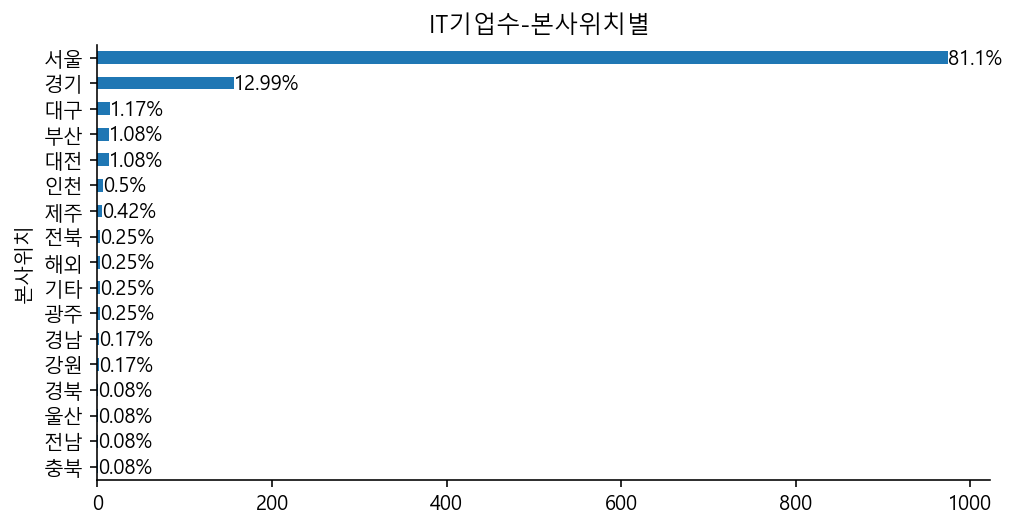

In [17]:
#시각화
plt.figure(figsize=(8,4))
grouped = df_company_list.value_counts('본사위치').sort_values()
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df_company_list)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('IT기업수-본사위치별 ')
plt.show()

- `평균별점`과 `평균연봉` 사이에 약한 양의 상관관계 존재

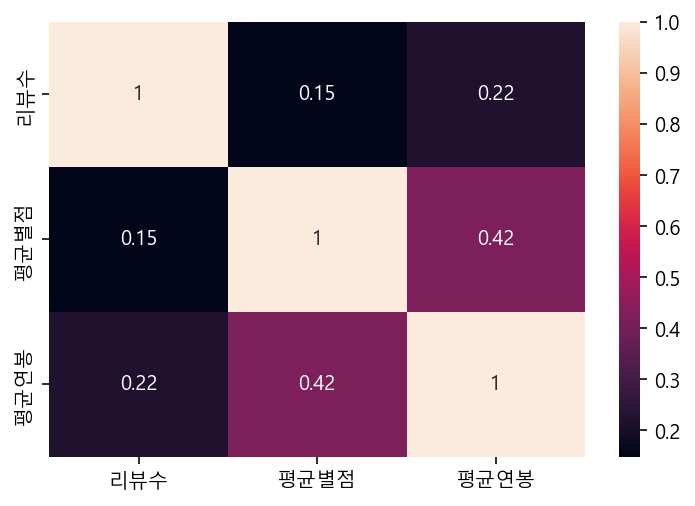

In [18]:
sns.heatmap(df_company_list.corr(), annot=df_company_list.corr());

- 리뷰수가 많을수록 평균연봉이 높다?
    - 리뷰작성수가 많을수록 기업의 규모가 크다고 유추
    - 기업의 규모가 클수록 - 연봉이 높을 가능성이 높다고 유추
        - 기업별 직원수 데이터가 있으면 조금더 정확한 분석이 가능하겠다.
- 리뷰수

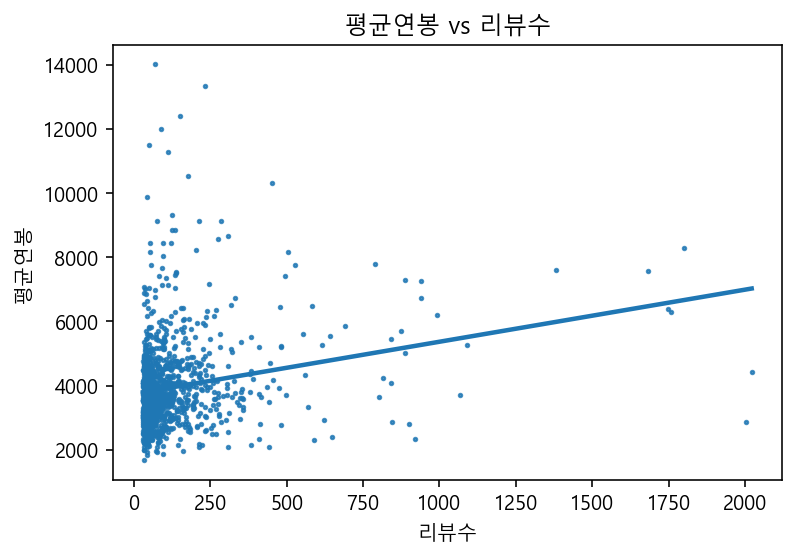

In [19]:
df = df_company_list
y='평균연봉'
x='리뷰수'

sns.regplot(y=y,x=x, data=df, ci=None, scatter_kws={'s':3})
plt.title('평균연봉 vs 리뷰수');

In [20]:
df_company_list['리뷰수_sq'] = df_company_list['리뷰수'] ** 2
df_company_list

,회사명,본사위치,리뷰수,평균별점,평균연봉,리뷰수_sq
index,,,,,,
0,(주)티몬,서울,2022,2.8,4426,4088484
1,(주)위메프,서울,2003,2.6,2874,4012009
2,삼성에스디에스(주),서울,1801,3.5,8296,3243601
3,(주)엘지씨엔에스,서울,1759,3.1,6293,3094081
4,(주)엘지유플러스,서울,1747,3.2,6375,3052009
...,...,...,...,...,...,...
1196,제이엔테크놀러지(주),서울,30,2.4,3808,900
1197,지니키즈(주),서울,30,2.7,3212,900
1198,콤위즈(주),서울,30,2.4,2794,900


In [21]:
order = df.groupby(['본사위치'])['평균별점'].mean().sort_values(ascending=False).index

In [22]:
df_company_list.sort_values('평균별점')

,회사명,본사위치,리뷰수,평균별점,평균연봉,리뷰수_sq
index,,,,,,
404,디자인커뮤니케이션(주),서울,100,1.2,2718,10000
880,(주)세이퍼존,대전,44,1.3,3639,1936
786,(주)아이네임즈,경기,51,1.3,2853,2601
731,헤이코리안(주),서울,56,1.4,4298,3136
965,아이리시스(주),서울,40,1.5,3311,1600
...,...,...,...,...,...,...
1092,(주)센드버드코리아,서울,34,4.4,4946,1156
666,라이엇게임즈코리아,해외,62,4.4,6337,3844
1185,(주)살다,서울,30,4.5,3518,900


In [23]:
df_company_list.sort_values('평균별점').head(5)['회사명']

index
404    디자인커뮤니케이션(주)
880         (주)세이퍼존
786        (주)아이네임즈
731        헤이코리안(주)
965        아이리시스(주)
Name: 회사명, dtype: object

In [24]:
df_company_list.sort_values('평균별점').head(5)['회사명']

index
404    디자인커뮤니케이션(주)
880         (주)세이퍼존
786        (주)아이네임즈
731        헤이코리안(주)
965        아이리시스(주)
Name: 회사명, dtype: object

# 리뷰데이터

## 데이터셋 불러오기

In [25]:
df_reviews = pd.read_csv('./input/df_reviews.csv', index_col=0,  low_memory=False)
print(df_reviews.shape)
df_reviews.head(3)

(148851, 19)


,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
0,티몬,50695,마케팅/시장조사,전직원,서울,2022. 04,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0
1,티몬,50695,영업/제휴,현직원,서울,2022. 04,3,5,5,5,1,1,"영업부서는 그나마 운영이 잘되나, 별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...",연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...,동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...,"신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...",비슷,추천,0
2,티몬,50695,디자인,현직원,서울,2022. 04,2,1,1,2,1,1,하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진,리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...,있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...,사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...,NaN,비추천,0


In [26]:
df_reviews.tail(3)

,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
148848,한국옐로우페이지,90425,NaN,현직원,NaN,NaN,2,2,2,2,2,2,공공기관 아래에서 중소기업을 돕는 업무는 진행하는 회사,공공기관 및 협회 업무에 대해서 직간접적인 경험을 할 수 있음,"직원의 희생에 대해서 당연시하는 경향 있으며,그 때문에 퇴사가 많은 편",회사를 발전시키고 싶다면 우선 직원의 삶이 발전해야 한다는 것을 알아야 함,비슷,비추천,3
148849,한국옐로우페이지,90425,NaN,현직원,NaN,NaN,2,3,2,2,1,2,중소기업과 가까이 일하는 회사.,국내 다양한 중소기업을 접해볼 수 있는 기회가 됨,요즘은 모르겠는데 예전엔 업무는 많은데 사람이 별로 없어서 힘들었음,업무배분이 효율적이면 좋을 것 같아요.,비슷,비추천,2
148850,한국옐로우페이지,90425,NaN,현직원,NaN,NaN,2,2,3,2,2,2,외국인 이면 들어가기 힘듭니다.마케팅 관심 필요,번역 알바생 으로 일을해봤는데 이주일에 하루만 근무,짧은 시간 동안 많은 양으로 번역 해야되기 때문에 스트래스 많이 받습니다,별로 추천하지 않습니다. 야근 준비 해야함,비슷,비추천,0


## 기본정보 확인

### info

In [27]:
df = df_reviews.copy()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148851 entries, 0 to 148850
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   회사명          148851 non-null  object
 1   회사코드         148851 non-null  int64 
 2   직군           128213 non-null  object
 3   전/현직원 구분     148851 non-null  object
 4   근무지역         125412 non-null  object
 5   작성월          128385 non-null  object
 6   별점           148851 non-null  int64 
 7   승진 기회 및 가능성  148851 non-null  int64 
 8   복지 및 급여      148851 non-null  int64 
 9   업무와 삶의 균형    148851 non-null  int64 
 10  사내문화         148851 non-null  int64 
 11  경영진          148851 non-null  int64 
 12  총평           148850 non-null  object
 13  장점           148851 non-null  object
 14  단점           148851 non-null  object
 15  경영진에 바라는 점   148763 non-null  object
 16  1년 후 기업 전망   104827 non-null  object
 17  기업 추천여부      148851 non-null  object
 18  게시글 추천 수     148851 non-null  int64 
dtypes:

### 결측치

- 잡플래닛 서비스 기간에 따라 의무 입력항목이 달라져서 결측치가 다수 존재
- 결측치에대한 의미가 있을지? 
    - unknown으로 대체

In [29]:
df.isnull().sum()

회사명                0
회사코드               0
직군             20638
전/현직원 구분           0
근무지역           23439
작성월            20466
별점                 0
승진 기회 및 가능성        0
복지 및 급여            0
업무와 삶의 균형          0
사내문화               0
경영진                0
총평                 1
장점                 0
단점                 0
경영진에 바라는 점        88
1년 후 기업 전망     44024
기업 추천여부            0
게시글 추천 수           0
dtype: int64

<AxesSubplot:>

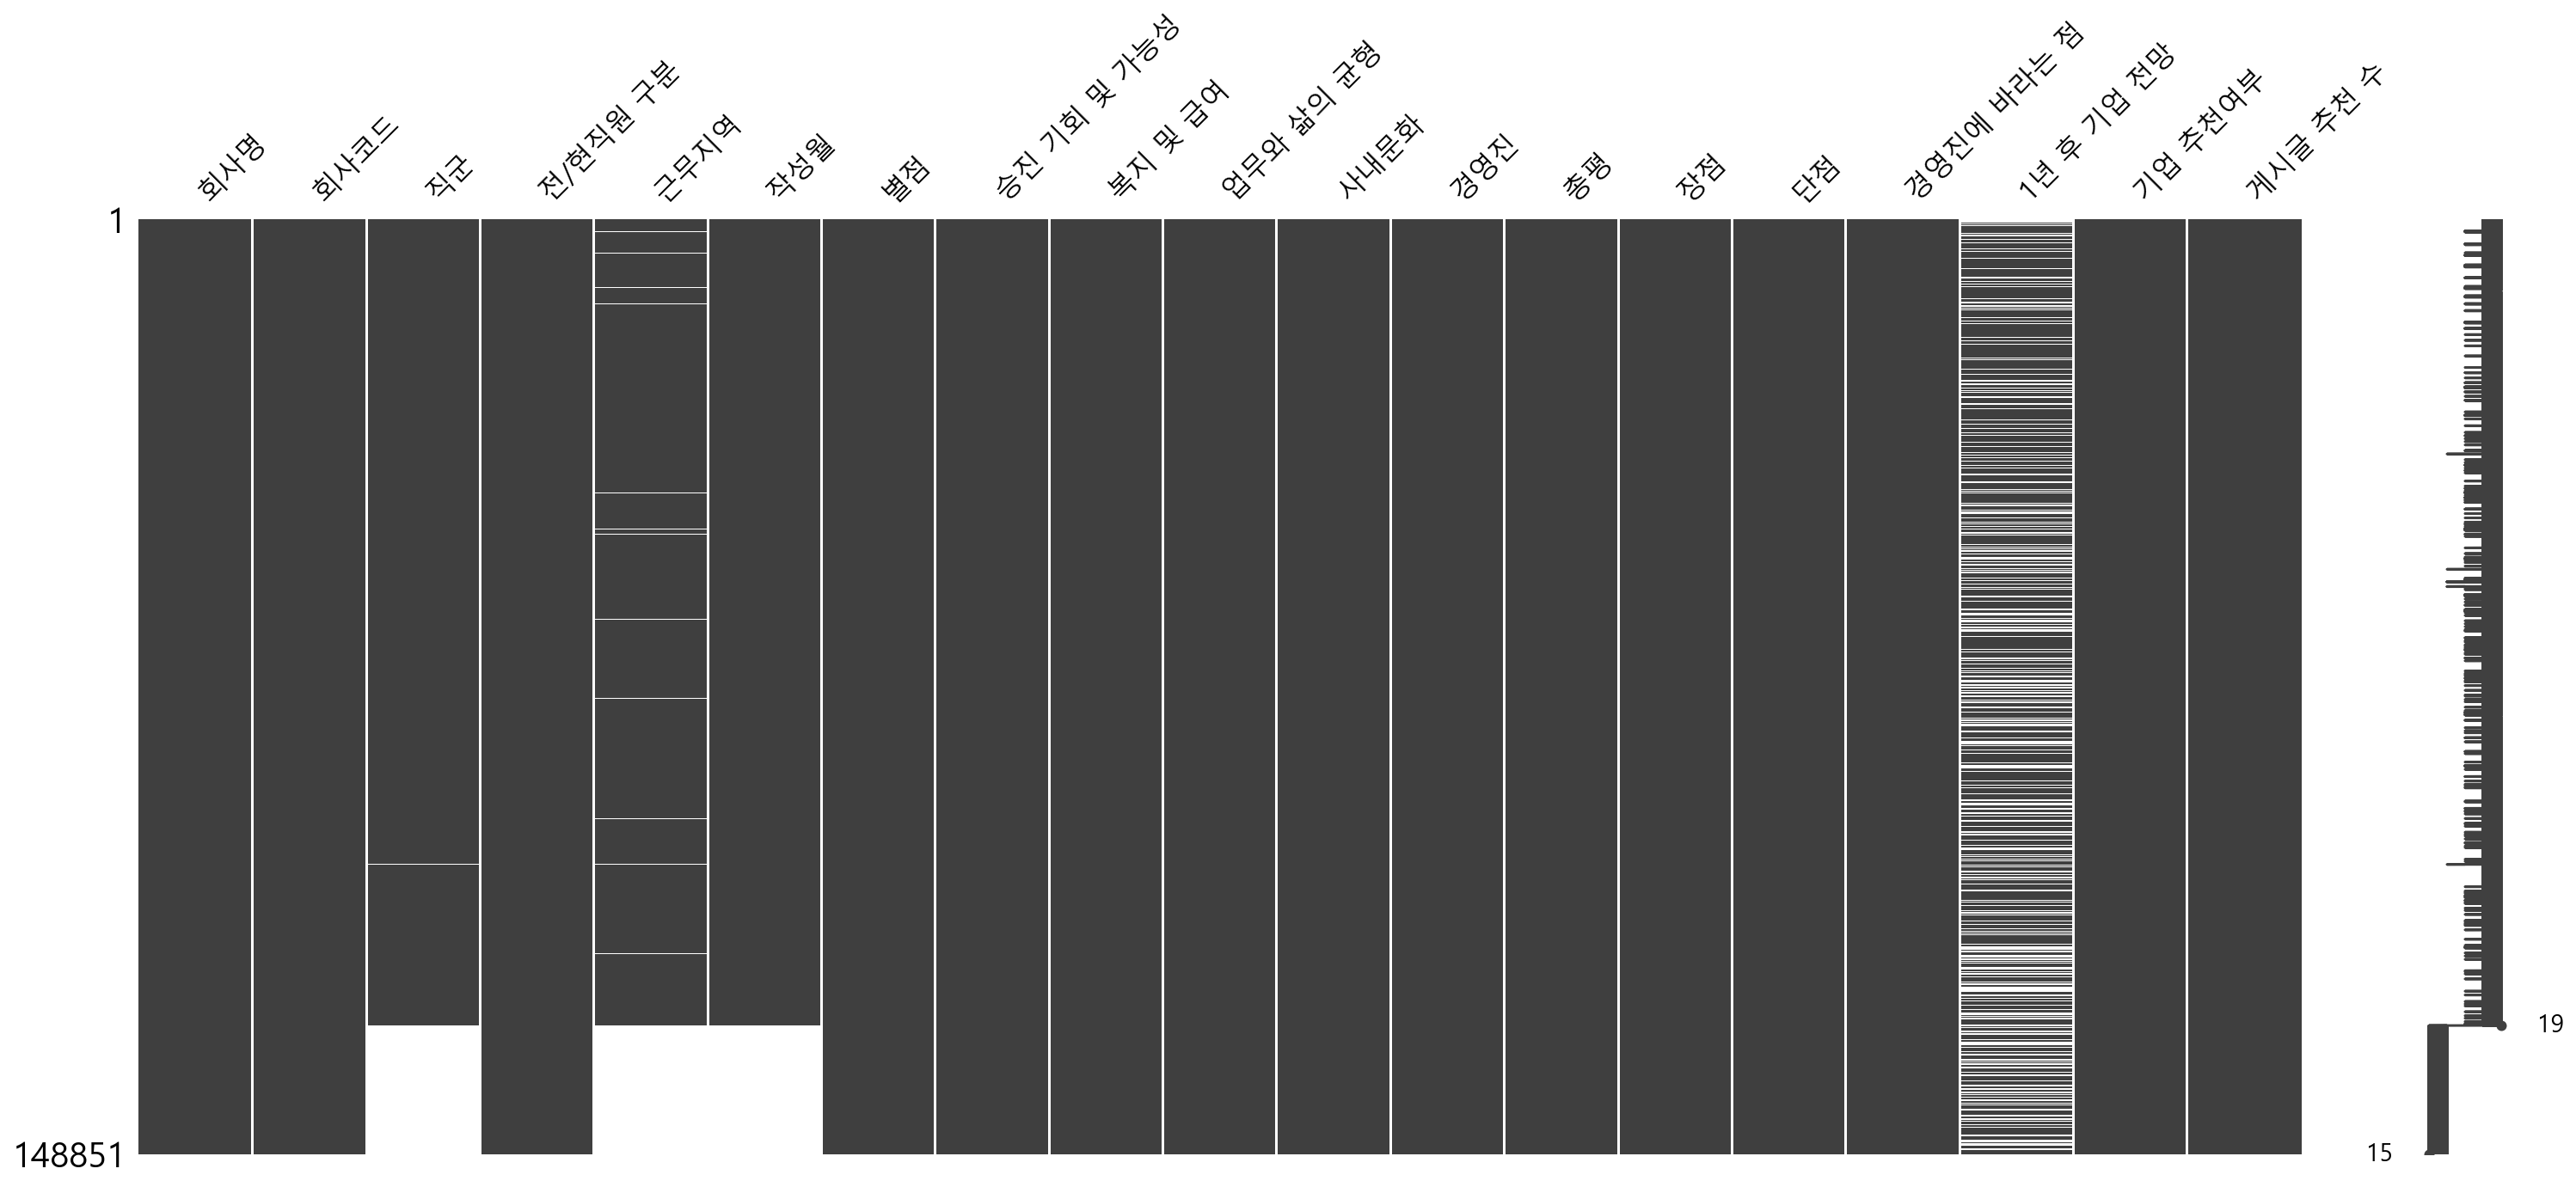

In [30]:
msno.matrix(df)

In [31]:
df = df.fillna('unknown')
df.isnull().sum()

회사명            0
회사코드           0
직군             0
전/현직원 구분       0
근무지역           0
작성월            0
별점             0
승진 기회 및 가능성    0
복지 및 급여        0
업무와 삶의 균형      0
사내문화           0
경영진            0
총평             0
장점             0
단점             0
경영진에 바라는 점     0
1년 후 기업 전망     0
기업 추천여부        0
게시글 추천 수       0
dtype: int64

### 중복값

- 스크레이핑 과정에서 중복값 8개 발생 -> 제거

In [32]:
df.duplicated().sum()

8

In [33]:
df[df.duplicated(keep=False)]

,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
5636,삼성에스디에스,30162,전문직,현직원,충남,2014. 09,4,3,4,3,3,3,"대기업의 시스템과 조직문화, 체계를배우기엔 좋지만 역피라미드구조라 신입사원은 스트레...",삼성계열사중 복지의 관심도가 높고 전문직이다보니 한분야를 폭넓게 경험하고 전문지식습...,"역피라미드구조, 일방적소통, 노사문화 등 이있겠다","변화하는시대에맞춰 제품이바뀌듯 모든면에서 바뀔필요가있다(마인드, 업무방식 등)",성장,추천,0
5637,삼성에스디에스,30162,전문직,현직원,충남,2014. 09,4,3,4,3,3,3,"대기업의 시스템과 조직문화, 체계를배우기엔 좋지만 역피라미드구조라 신입사원은 스트레...",삼성계열사중 복지의 관심도가 높고 전문직이다보니 한분야를 폭넓게 경험하고 전문지식습...,"역피라미드구조, 일방적소통, 노사문화 등 이있겠다","변화하는시대에맞춰 제품이바뀌듯 모든면에서 바뀔필요가있다(마인드, 업무방식 등)",성장,추천,0
9309,엘지유플러스,63857,IT/인터넷,현직원,unknown,2014. 05,3,3,4,3,3,3,회사 네임밸류와 복지가 훌륭하여 회사에 대한 프라이드를 가지고 업무에 임할 수 있다,공정한 평가제도가 마련되어있는편이고\n나름 여유있는 직장생활 가능,보수적이고 진취적인 정신이 없음\n최근 구조조정 등으로 인한 불안감,업무 배분이 효율적으로 이뤄졌으면 좋겠음,비슷,비추천,0
9310,엘지유플러스,63857,IT/인터넷,현직원,unknown,2014. 05,3,3,4,3,3,3,회사 네임밸류와 복지가 훌륭하여 회사에 대한 프라이드를 가지고 업무에 임할 수 있다,공정한 평가제도가 마련되어있는편이고\n나름 여유있는 직장생활 가능,보수적이고 진취적인 정신이 없음\n최근 구조조정 등으로 인한 불안감,업무 배분이 효율적으로 이뤄졌으면 좋겠음,비슷,비추천,0
10841,케이티,53191,IT/인터넷,현직원,서울,2014. 07,3,3,3,4,3,2,"무엇을 배우기 보단, 스스로 공부하기엔 좋은 회사",경우에 따라 다르지만 업무강도가 그렇게 심하지 않다. 일정에 대해 무리한 요구를 하...,다른 회사에 비해 급여가 상대적으로 적다. 인사제도 바뀌면서 어떻게 될지 모르겠는데...,공기업 태생의 회사라서 그런지 변화에 적응하는 속도와 의사결정이 매우 답답하다. 이...,비슷,비추천,0
10842,케이티,53191,IT/인터넷,현직원,서울,2014. 07,3,3,3,4,3,2,"무엇을 배우기 보단, 스스로 공부하기엔 좋은 회사",경우에 따라 다르지만 업무강도가 그렇게 심하지 않다. 일정에 대해 무리한 요구를 하...,다른 회사에 비해 급여가 상대적으로 적다. 인사제도 바뀌면서 어떻게 될지 모르겠는데...,공기업 태생의 회사라서 그런지 변화에 적응하는 속도와 의사결정이 매우 답답하다. 이...,비슷,비추천,0
10854,케이티,53191,경영/기획/컨설팅,현직원,unknown,2014. 07,3,2,2,3,3,1,갈수록 더 어려워지는 상황\n평생 케이티에서 근무한다면 근무 분위기\n업무강도 등은...,타사에 비해 편한 근무 분위기\n국내 대기업으로 누리는 복지와 신분보장,"비합리적인 인사, 매일 바뀌는 경영 정책,\n야근이 없지만 부서에 따라 복불복\n일...",체계적인 평가와 인력 운영\n보여주기식 성과에 집중하는 일 없었으면\n추가적 인력구...,unknown,비추천,0
10855,케이티,53191,경영/기획/컨설팅,현직원,unknown,2014. 07,3,2,2,3,3,1,갈수록 더 어려워지는 상황\n평생 케이티에서 근무한다면 근무 분위기\n업무강도 등은...,타사에 비해 편한 근무 분위기\n국내 대기업으로 누리는 복지와 신분보장,"비합리적인 인사, 매일 바뀌는 경영 정책,\n야근이 없지만 부서에 따라 복불복\n일...",체계적인 평가와 인력 운영\n보여주기식 성과에 집중하는 일 없었으면\n추가적 인력구...,unknown,비추천,0
56849,펜타브리드,86734,IT/인터넷,전직원,서울,2022. 04,3,4,2,4,3,2,디자이너 위주의 회사 나머지 직군은 별로,대외적을 평판이 좋은편에 속한다. 아는 사람은 다아는 정도의 웹에이젼시,효율적이지 않음. 경력직 위주 보다는 신입 위주로 돌림.\n능력 보다는.... 수입...,신규 사업도 하고 범위를 넓여야지.... 하던일만 너무 할려고 함.,비슷,비추천,0


In [34]:
# 중복값 제거
print('제거 전:',df.shape)
df = df.drop_duplicates()
print('제거 후:',df.shape)

제거 전: (148851, 19)
제거 후: (148843, 19)


- 하기 총 4개 기업에 대하여 회사코드를 접미사로 붙여 중복값문제 해결
    - 데이타솔루션 -> 기업리스트와 똑같은 문제
    - (주)유시스, 유시스(주) -> (주) 제거되면서 해당 문제 발생

In [35]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

,회사명,회사코드
126,데이타솔루션,86935
127,데이타솔루션,89732
759,유시스,59945
760,유시스,59946


In [36]:
# 중복값되는 회사명에 접미사 추가 
df['회사명'] = df.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='데이타솔루션' or x['회사명']=='유시스' else x['회사명'], axis=1)

In [37]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

,회사명,회사코드


In [38]:
# 회사명 확인
df[df['회사명'].str.contains('데이타솔루션')].head(1)

,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
112543,데이타솔루션_89732,89732,IT/인터넷,전직원,서울,2022. 02,3,3,2,1,3,2,"나름 규모가 커진 상장된 SI회사, 대체적으로 업무 강도 강함, 연봉 수준은 중소기...",임원 제외 사원~부장 내에서는 친해지면 편한 관계로 일할 수 있음. 업무 강도가 강...,공공기관 사업이 주인데 요구사항이 너무 터무니 없어서 물리적으로 어쩔 수 없이 나중...,"작성한 본인도 그렇고 요즘 코더들이 많은데, 급한대로 데려와서 쓰더라도 사업이 끝난...",비슷,비추천,0


In [39]:
df[df['회사명'].str.contains('유시스')].head(1)

,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
141416,유시스_59946,59946,unknown,현직원,unknown,unknown,5,5,2,3,1,2,개발자가 대우받는 기업. 아직은 많은 발전이 진행중임. 드론관련 사업의 선두주자,본인이 하고싶은 일은 언제든지 상사와 협의하여 편하게 일할수 있음,징기 근속자가 많지 안음. 소기업의 어려운점일것 같음. 회사가 이익이 발생하는 사업...,경영자의 방향제시가 명확하고 확고할 필요가 있음. 경영진의 고민이 필요함,비슷,비추천,0


### 기타 
- `회사코드` 제거

In [40]:
df.drop('회사코드', axis=1, inplace=True)

## 전처리

### `직군`

- 'IT-인터넷' -> 'IT/인터넷' 으로 통일

In [41]:
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'IT-인터넷',
       'unknown'], dtype=object)

In [42]:
df['직군'] = df['직군'].apply(lambda x:x.replace('-','/') if not isinstance(x, float) else x)
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'unknown'],
      dtype=object)

### `작성월`
- 불량 데이터 -> 결측치 변환 
    - '이 기업의 댓글' -> np.nan

In [43]:
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

In [44]:
# 스크레이핑 에러 제거
# 이 기업의 댓글 -> np.nan
df['작성월'] = np.where(df['작성월']=='이 기업의 댓글', np.nan, df['작성월'])
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

## 분석

### `직군`

- IT/인터넷 직군이 전체의 49.01% 차지 
    - IT직군 여부에 따른 점수 차이 있을까?
- 다음으로 경영/기획/컨설팅, 영업/제휴 순
- 기재하지 않은 경우가 전체의 13.87%
    - 직군 포함 데이터를 모두 작성하지 않은경우의 점수가 더 낮을까?

- @
    - 상세직군이 나오면 분석이 더 용이할것 같은데, 상세하게 적으면 누군지 추적이 되니까 상세하게 기재하지 못할 것 같다. 
    - 직군을 가짜로 기재한 경우도 있을까?

In [45]:
grouped = pd.DataFrame(df['직군'].value_counts())
grouped['비율(%)'] = df['직군'].value_counts(normalize=True).round(4)*100
grouped.head(10)

,직군,비율(%)
IT/인터넷,72944,49.01
unknown,20638,13.87
경영/기획/컨설팅,10774,7.24
영업/제휴,9236,6.21
마케팅/시장조사,8635,5.80
디자인,6801,4.57
서비스/고객지원,6794,4.56
미디어/홍보,2737,1.84
인사/총무,1796,1.21
금융/재무,1519,1.02


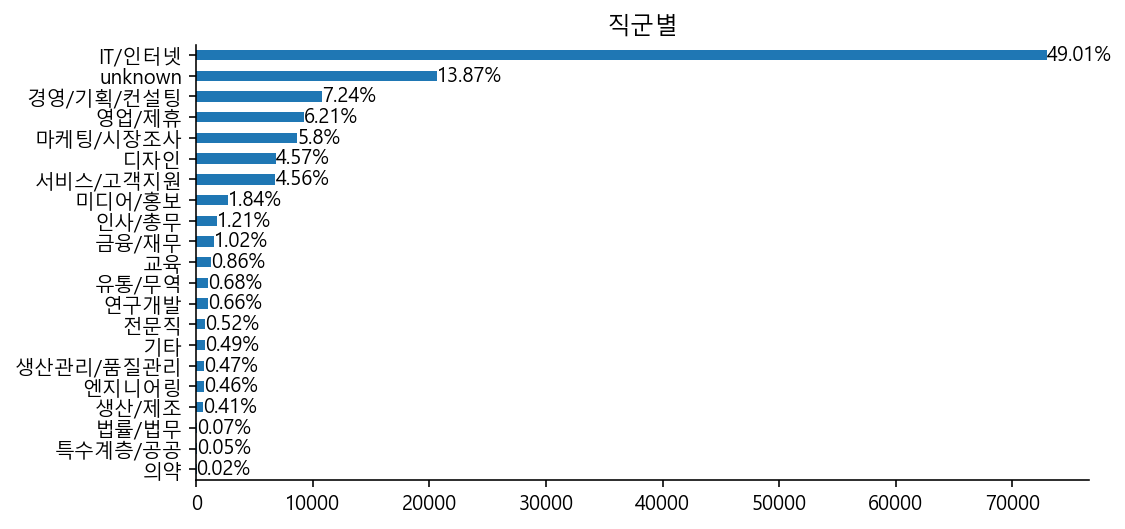

In [46]:
#시각화
x = '직군'
grouped = df['직군'].value_counts().sort_values()

plt.figure(figsize=(8,4))
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('직군별')
plt.show()

- IT직군 vs 비 IT직군 평균 점수 차이가 날지?

In [47]:
# IT여부 컬럼 생성
cond = df['직군'] == 'IT/인터넷'
df['IT여부'] = np.where(cond, 1, 0)
df.head(1)

,회사명,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부
index,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022. 04,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0,0


In [48]:
subset = ['회사명','직군','IT여부','전/현직원 구분','근무지역','작성월',
          '별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']
id_vars = subset[:6]
value_vars = subset[6:]

df_score = df[subset]
df_score_melted = df_score.melt(id_vars=id_vars, value_vars=value_vars, var_name='항목', value_name='점수')
df_score_melted.head()

,회사명,직군,IT여부,전/현직원 구분,근무지역,작성월,항목,점수
0,티몬,마케팅/시장조사,0,전직원,서울,2022. 04,별점,3
1,티몬,영업/제휴,0,현직원,서울,2022. 04,별점,3
2,티몬,디자인,0,현직원,서울,2022. 04,별점,2
3,티몬,영업/제휴,0,현직원,서울,2022. 04,별점,3
4,티몬,IT/인터넷,1,전직원,기타,2022. 04,별점,3


In [49]:
cond = df_score_melted['직군'] == 'IT/인터넷'
df_score_melted['IT여부'] = np.where(cond, 1, 0)
grouped = df_score_melted.groupby(['IT여부','항목'])['점수'].mean().reset_index()
grouped

,IT여부,항목,점수
0,0,경영진,2.365960
1,0,별점,2.778363
2,0,복지 및 급여,2.628599
3,0,사내문화,2.861750
4,0,승진 기회 및 가능성,2.718863
5,0,업무와 삶의 균형,2.943833
6,1,경영진,2.298133
7,1,별점,2.830308
8,1,복지 및 급여,2.671145
9,1,사내문화,2.879140


- histplot
    - 비 IT 직군이 1점 비율이 많아 보이는데 한눈에 파악하기 어렵다

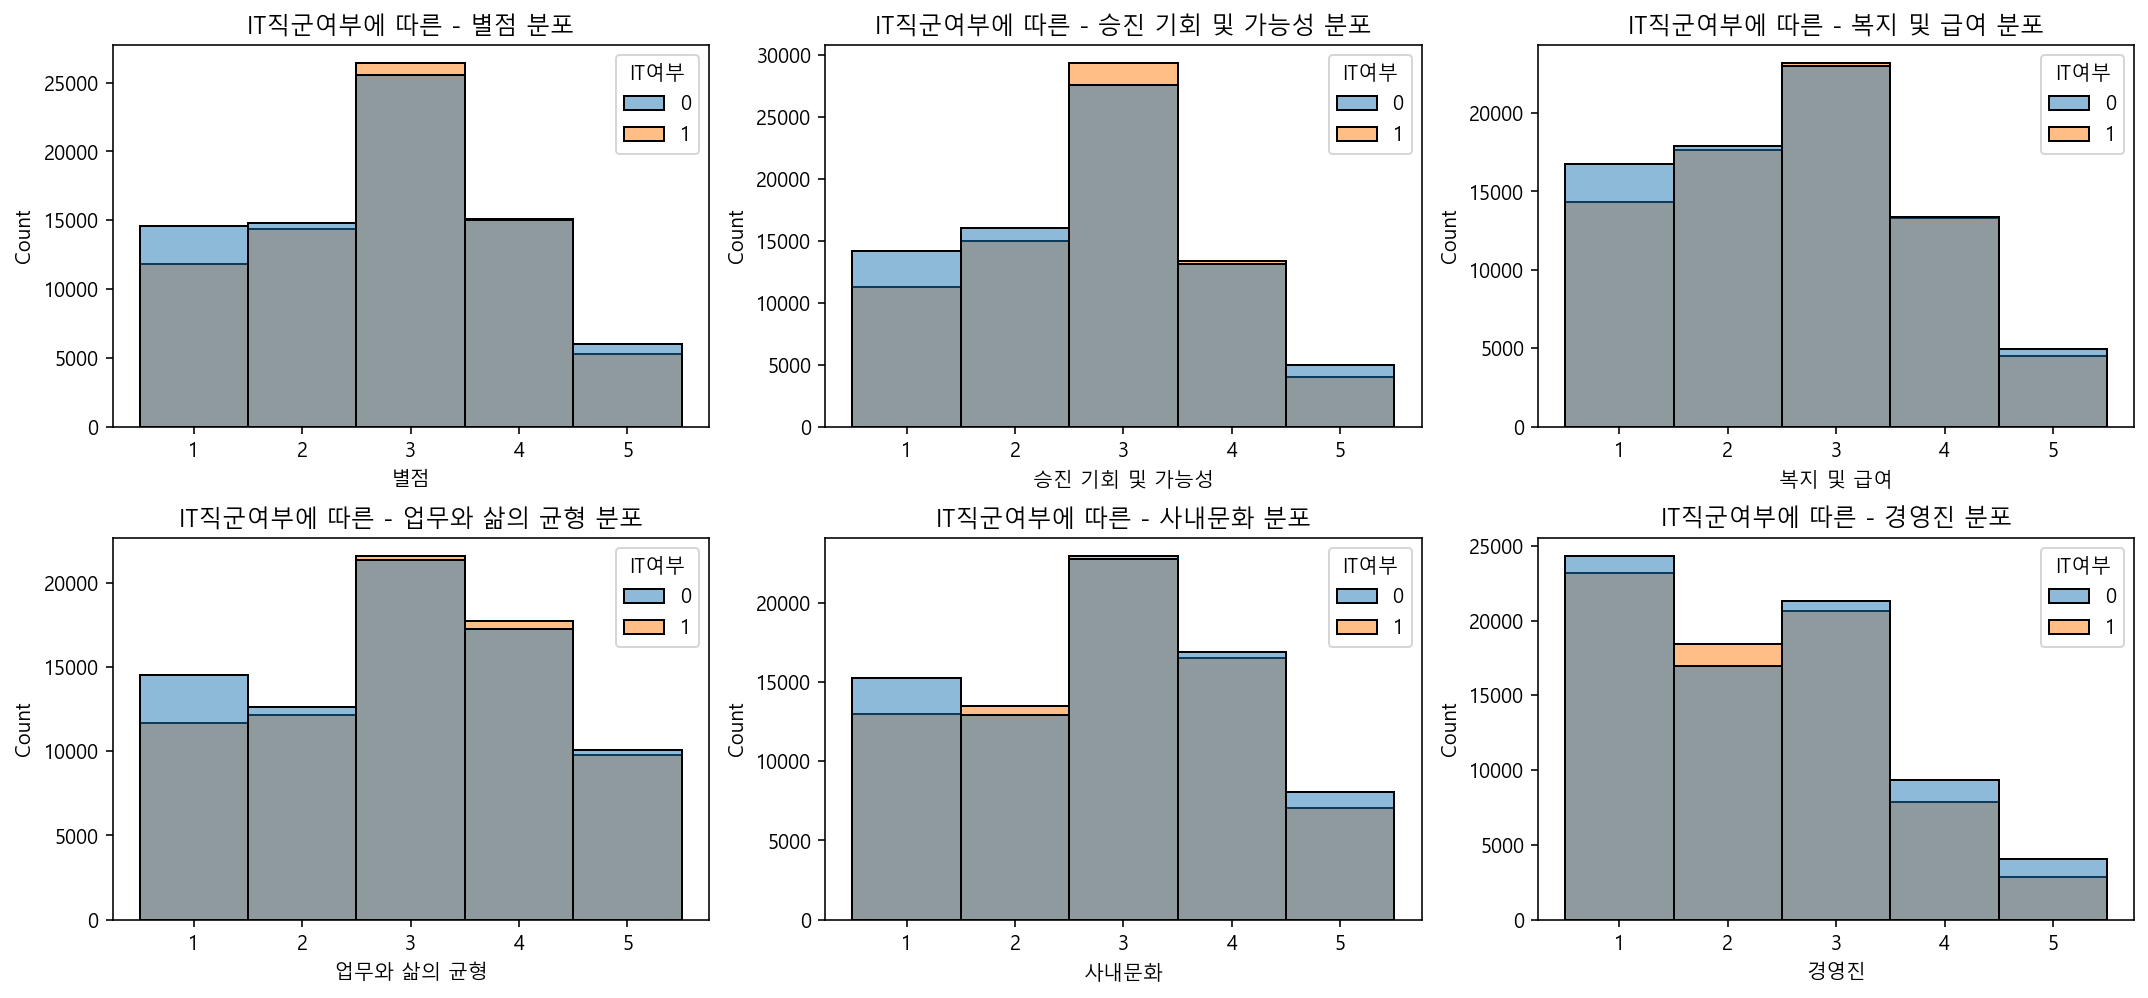

In [50]:
# 시각화 - 히스토그램 
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

fig,ax = plt.subplots(2, 3, figsize=(15,7))
for idx, col in enumerate(arr_scores):
    x = col
    r,c = idx//3, idx%3
    g = sns.histplot(x=x, data=df, discrete=True, hue='IT여부', ax=ax[r,c], )
    g.set_title(f'IT직군여부에 따른 - {col} 분포')
plt.tight_layout()
plt.show()

- point plot
    - 경영진에 대한 점수외 모든 항목에서 IT직군의 평균점수가 높다. 

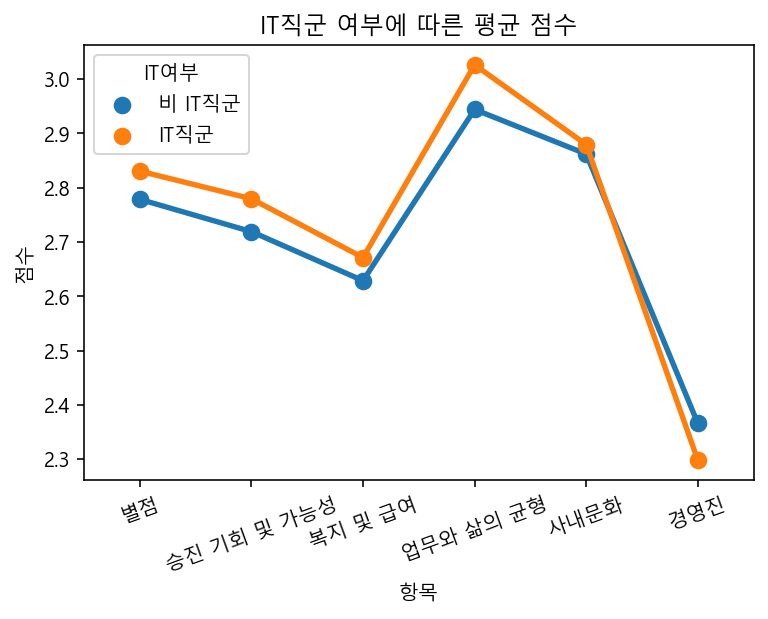

In [51]:
# 시각화
y='점수'
x='항목'

g = sns.pointplot(y='점수',x='항목',data=grouped, hue='IT여부', order=arr_scores)

plt.title('IT직군 여부에 따른 평균 점수')

plt.xticks(rotation=20)


leg = g.axes.get_legend()
leg.set_title('IT여부')
new_labels = ['비 IT직군', 'IT직군']

for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.show()

- Two sample T Test
    - 두 집단의 평균 차이가 있는지 
    - 집단이 서로 등분산성을 보이지 않을 때
        - Levene Test : 두 집단 분산의 차이가 있는지 검정
            - H0: 두 집단의 분산이 같다(차이가 없다.). 
            - H1: 두 집단의 분산이 다르다. 

- Levene Test
    - 모든 항목의 p_value < 0.05 : 귀무가설 기각
    - 모든 항목에서의 두 집단의 분산이 다르다.
    - Two sample T Test 진행 가능

In [52]:
# IT직군 여부에 따른 그룹 분할
cond = df['IT여부'] == 1
df_it = df[cond][arr_scores]
df_non_it = df[~cond][arr_scores]

In [53]:
from scipy import stats
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

for col in arr_scores:
    t_test = stats.levene(df_it[col], df_non_it[col])
    print(col)
    print(t_test)
    print('====='*15)

별점
LeveneResult(statistic=236.21404944703943, pvalue=2.8922842697409404e-53)
승진 기회 및 가능성
LeveneResult(statistic=422.6908394058495, pvalue=8.559677637239754e-94)
복지 및 급여
LeveneResult(statistic=113.2540058479425, pvalue=1.9403541522829847e-26)
업무와 삶의 균형
LeveneResult(statistic=121.64849196272587, pvalue=2.8263011527003385e-28)
사내문화
LeveneResult(statistic=140.37597509352648, pvalue=2.2780682974285625e-32)
경영진
LeveneResult(statistic=364.79507764326223, pvalue=3.183715737957122e-81)


- 가설검정
    - H0 : IT 그룹의 평균점수가 더 크지 않다.
    - H1 : IT 그룹의 평균점수 더 크다.
        - p_value < 0.05 : 귀무가설 기각
        - IT 그룹의 평균점수가 더 크다 
        - (경영진항목의 경우 IT 그룹의 점수가 비IT 그룹의 점수보다 크지않다.)

In [54]:
from scipy import stats
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

for col in arr_scores:
    t_test = stats.ttest_ind(df_it[col], df_non_it[col], equal_var=True, alternative='greater')
    print(col)
    print(t_test)
    print('====='*15)

별점
Ttest_indResult(statistic=8.557115033982583, pvalue=5.84010882725943e-18)
승진 기회 및 가능성
Ttest_indResult(statistic=10.444590036739191, pvalue=7.915613618283983e-26)
복지 및 급여
Ttest_indResult(statistic=6.976298968700512, pvalue=1.52157308161813e-12)
업무와 삶의 균형
Ttest_indResult(statistic=12.371994924141624, pvalue=1.9278080144107655e-35)
사내문화
Ttest_indResult(statistic=2.694618942476881, pvalue=0.0035238538532013143)
경영진
Ttest_indResult(statistic=-11.189317189828259, pvalue=1.0)


### `전/현직원 구분`

- 가설 : 전직원이 현직원에 비해 점수가 낮을 것이다.

- histplot
    - 전직원의 1,2,3점 분포가 더 커보인다. 

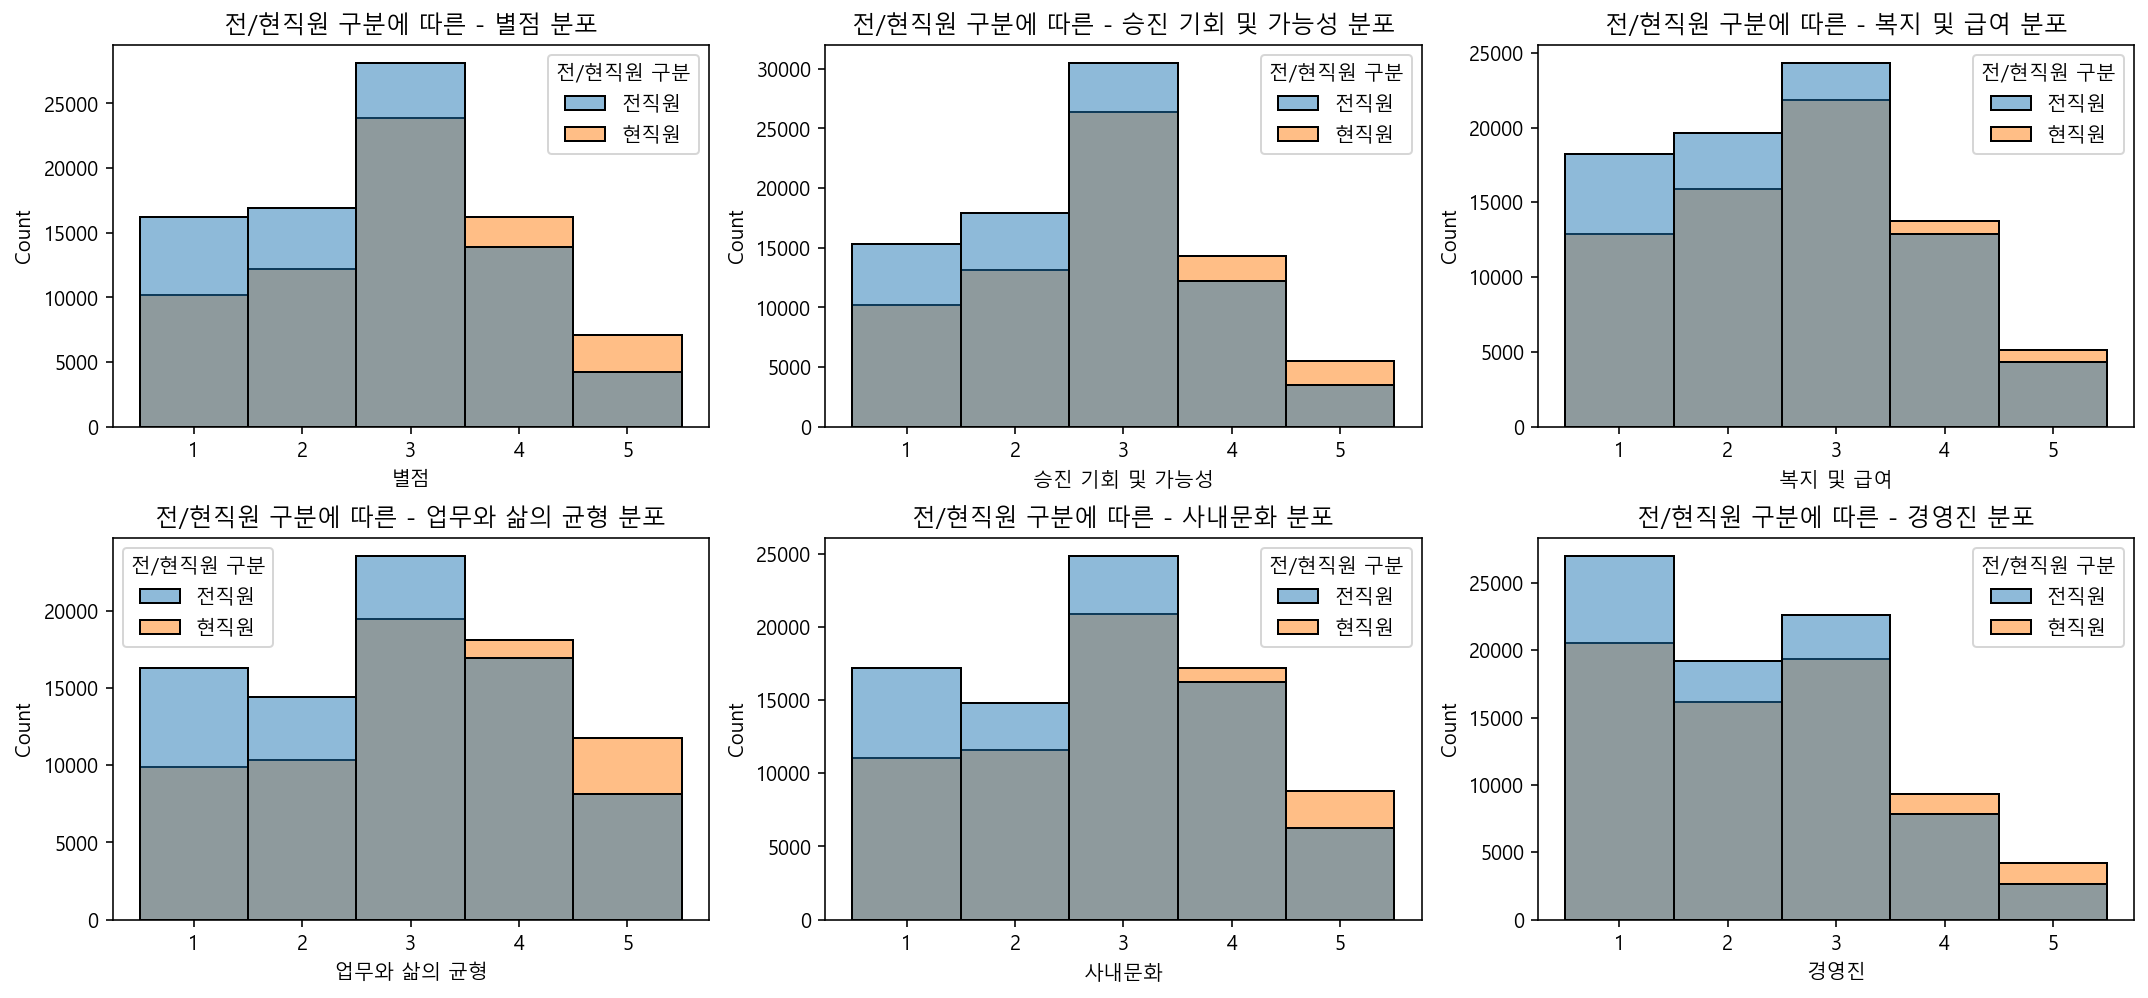

In [55]:
# 시각화 - 히스토그램 
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

fig,ax = plt.subplots(2, 3, figsize=(15,7))
for idx, col in enumerate(arr_scores):
    x = col
    r,c = idx//3, idx%3
    g = sns.histplot(x=x, data=df, discrete=True, hue='전/현직원 구분', ax=ax[r,c] )
    g.set_title(f'전/현직원 구분에 따른 - {col} 분포')
plt.tight_layout()
plt.show()

- point plot
    - 모든 점수에서 전직원의 평균평점이 상대적(현직원대비)으로 낮다.
    - 통계검정까지는 필요 없을 듯

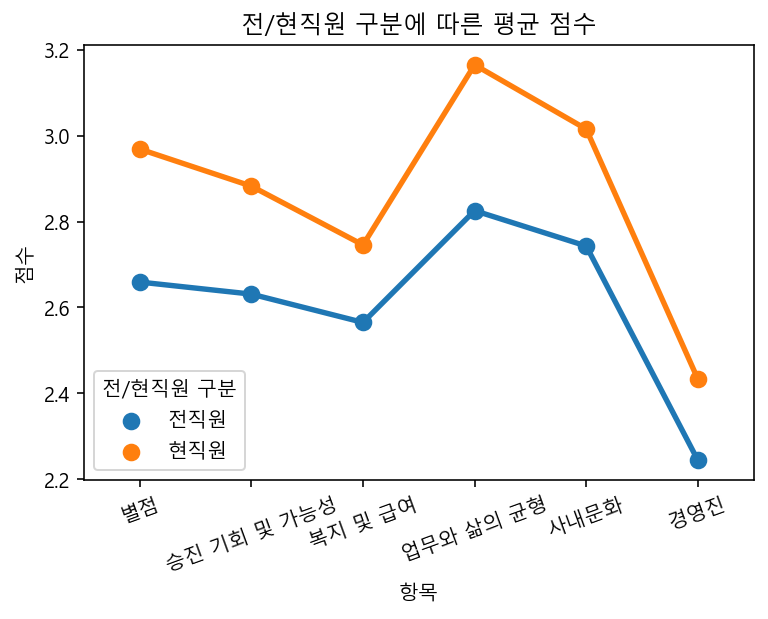

In [56]:
grouped = df_score_melted.groupby(['전/현직원 구분','항목'])['점수'].mean().reset_index()

y='점수'
x='항목'

sns.pointplot(y='점수',x='항목',data=grouped, hue='전/현직원 구분', order=arr_scores)
plt.xticks(rotation=20)
plt.title('전/현직원 구분에 따른 평균 점수')
plt.show()

- 퇴사자들의 text 데이터 분석 추가 

### `근무지역`

- 수도권 근무 여부
    - 가설 : 수도권 근무자의 만족도가 높을 것이다. 

In [57]:
cond = df['근무지역'].isin(['서울','경기','인천'])
df['수도권여부'] = np.where(cond,'수도권','비수도권')
df.head(1)

,회사명,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부
index,,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022. 04,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0,0,수도권


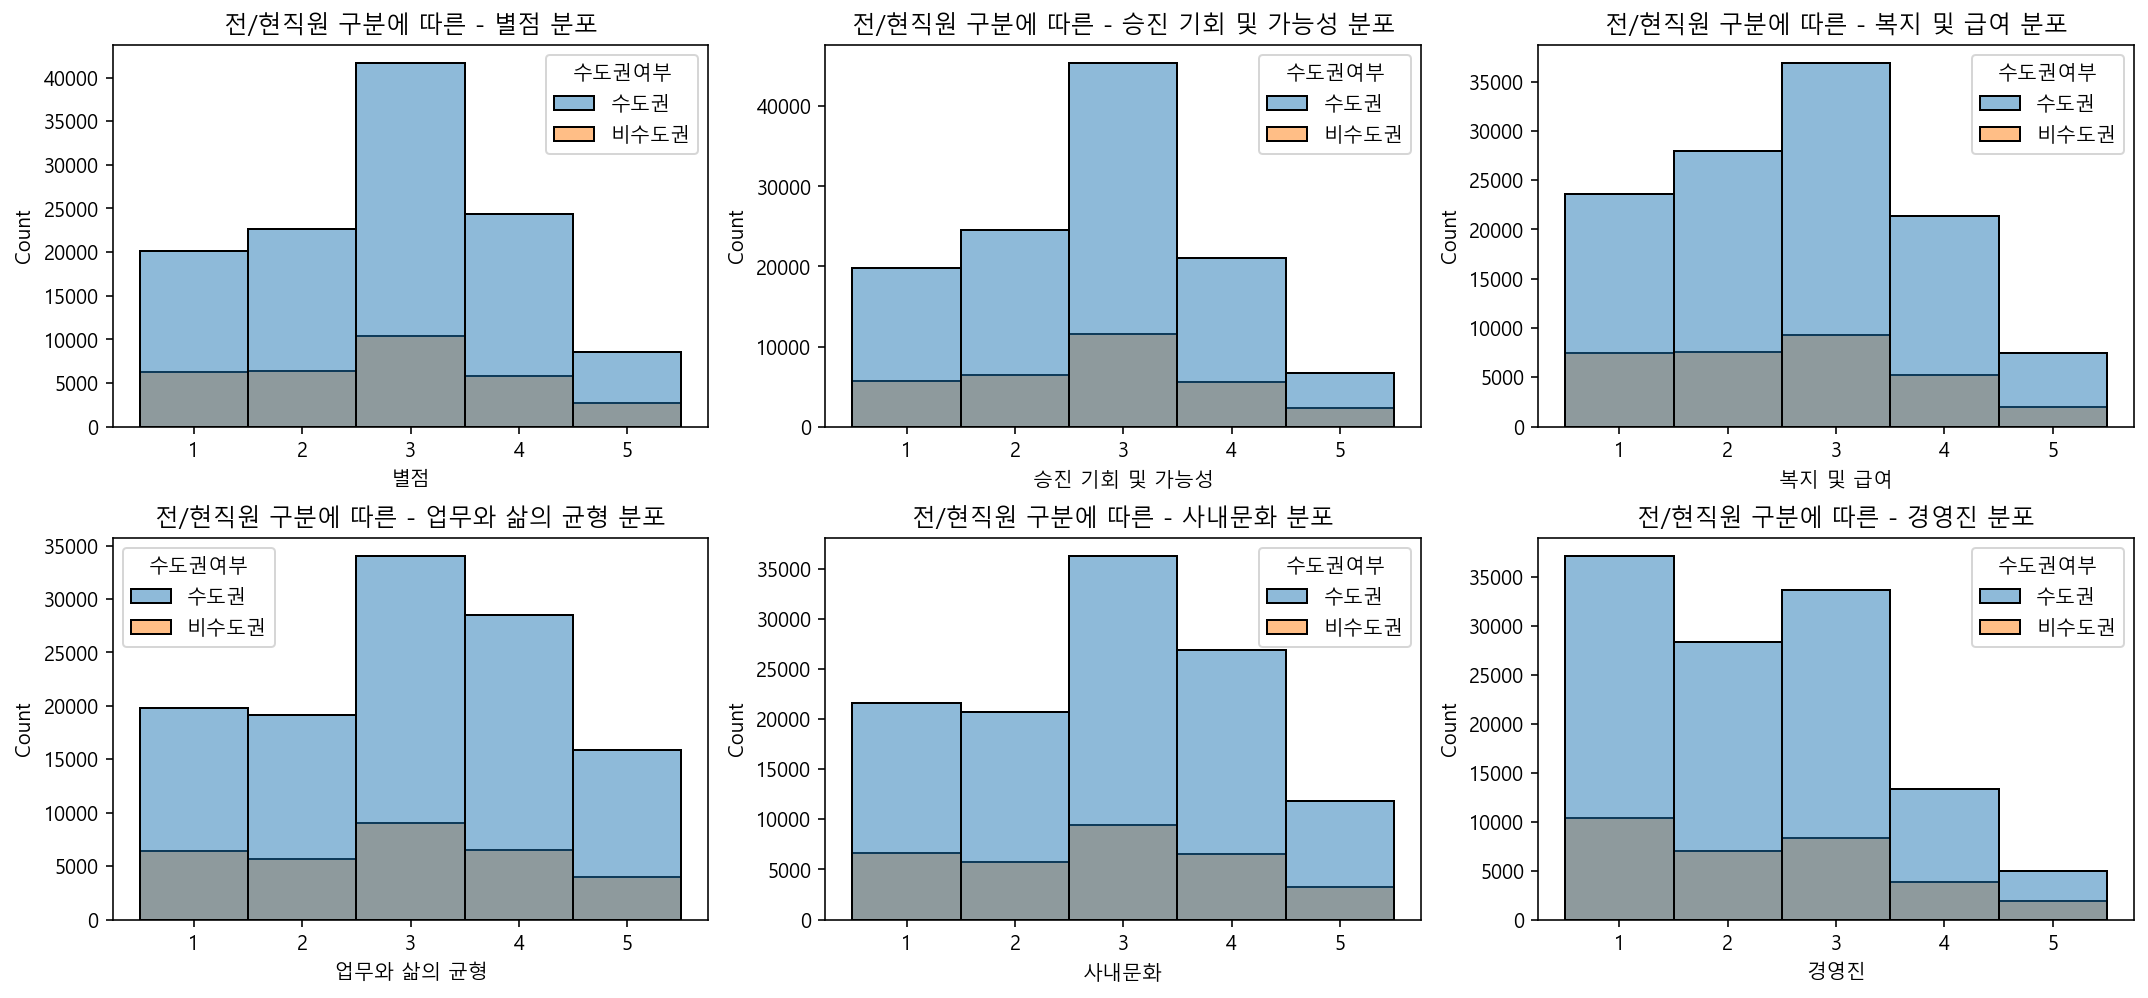

In [58]:
# 시각화 - 히스토그램 
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

fig,ax = plt.subplots(2, 3, figsize=(15,7))
for idx, col in enumerate(arr_scores):
    x = col
    r,c = idx//3, idx%3
    g = sns.histplot(x=x, data=df, discrete=True, hue='수도권여부', ax=ax[r,c], )
    g.set_title(f'전/현직원 구분에 따른 - {col} 분포')
plt.tight_layout()
plt.show()

In [59]:
subset = ['회사명','직군','IT여부','전/현직원 구분','근무지역','수도권여부','작성월',
          '별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']
id_vars = subset[:7]
value_vars = subset[7:]

df_score = df[subset]
df_score_melted = df_score.melt(id_vars=id_vars, value_vars=value_vars, var_name='항목', value_name='점수')

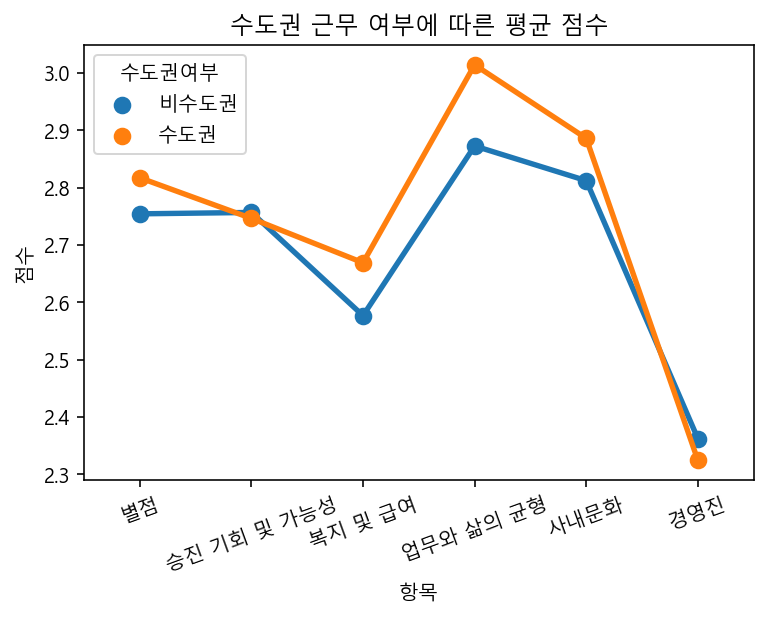

In [60]:
grouped = df_score_melted.groupby(['수도권여부','항목'])['점수'].mean().reset_index()

y='점수'
x='항목'

sns.pointplot(y='점수',x='항목',data=grouped, hue='수도권여부', order=arr_scores)
plt.xticks(rotation=20)
plt.title('수도권 근무 여부에 따른 평균 점수')
plt.show()

- levene test

In [61]:
# IT직군 여부에 따른 그룹 분할
cond = df['수도권여부'] == '수도권'
df_cap = df[cond][arr_scores]
df_ncap = df[~cond][arr_scores]

from scipy import stats
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']

for col in arr_scores:
    t_test = stats.levene(df_cap[col], df_ncap[col])
    print(col)
    print(t_test)
    print('====='*15)

별점
LeveneResult(statistic=191.38305510624818, pvalue=1.6881823188737927e-43)
승진 기회 및 가능성
LeveneResult(statistic=110.66915755030799, pvalue=7.139629721432412e-26)
복지 및 급여
LeveneResult(statistic=117.09099277132863, pvalue=2.8068891580306356e-27)
업무와 삶의 균형
LeveneResult(statistic=38.18903759798227, pvalue=6.437778277730776e-10)
사내문화
LeveneResult(statistic=58.2797014977001, pvalue=2.2872305863934573e-14)
경영진
LeveneResult(statistic=193.31714305933565, pvalue=6.394712806096286e-44)


- 가설검정
    - H0 : 수도권 근무자의 평균 점수가 더 높지않을것이다.
    - H1 : 수도권 근무자의 평균 점수가 더 높을것이다.    

In [62]:
# 가설검정 함수 설정
def ttest(df, hue_var, hue_val):
    arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']
    cond = df[hue_var] == hue_val
    df_a = df[cond][arr_scores]
    df_b = df[~cond][arr_scores]
    
    for col in arr_scores:
        t_test = stats.ttest_ind(df_a[col], df_b[col], equal_var=True, alternative='greater')
        print(col)
        print(t_test)
        print('====='*15)    

- 승진 기회 및 가능성, 경영진 : 수도권 근무자의 평균 점수가 높지않다. 
- 그 외 : 수도권 근무자의 평균 점수가 더 높다.  

In [63]:
# 가설검정 실시
ttest(df, '수도권여부', '수도권')

별점
Ttest_indResult(statistic=8.466207997754509, pvalue=1.2788441408166907e-17)
승진 기회 및 가능성
Ttest_indResult(statistic=-1.4664366969284615, pvalue=0.928734266125275)
복지 및 급여
Ttest_indResult(statistic=12.367937308306548, pvalue=2.0275905513546662e-35)
업무와 삶의 균형
Ttest_indResult(statistic=17.437188174205538, pvalue=2.5175972714074725e-68)
사내문화
Ttest_indResult(statistic=9.345857148917412, pvalue=4.6175077001965595e-21)
경영진
Ttest_indResult(statistic=-5.095732131651963, pvalue=0.9999998260902256)


### `작성월`

- 결측치가 왜 다시 생겼지?

In [64]:
# 결측치 처리
df['작성월'] = df['작성월'].fillna('unknown')
# 
df['작성년도'] = df['작성월'].apply(lambda x:x.split('. ')[0])

In [65]:
df.groupby('작성년도').size()

작성년도
2014        7429
2015       11617
2016       10825
2017        7554
2018       14437
2019       19501
2020       20636
2021       27702
2022        8636
unknown    20506
dtype: int64

In [66]:
# 결측치가 처리된 데이터셋 생성
cond = df['작성년도'] == 'unknown'
tmp = df[~cond]

In [67]:
# 연도별 테이블 생성 
grouped = tmp[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.118455,2.927778,2.800554,2.625232,2.735887,2.790524,2.825160,2.818352,2.872279
승진 기회 및 가능성,3.005384,2.845657,2.792148,2.648928,2.696821,2.704733,2.722233,2.735795,2.796318
복지 및 급여,2.843990,2.743221,2.683233,2.547789,2.617511,2.673094,2.693642,2.662804,2.676239
업무와 삶의 균형,2.999731,2.852113,2.808591,2.768202,2.916672,3.019999,3.070169,3.134611,3.179018
사내문화,3.138780,2.986141,2.945774,2.810696,2.826972,2.864930,2.870469,2.851852,2.876216
경영진,2.528335,2.393217,2.348268,2.215383,2.289672,2.313471,2.356997,2.306584,2.334414


- 2017년도에 무슨일이? 
    - 2017년에 모든항목 평점 최저치 
- 업무와 삶의 균형 -> 2018년부터 매우 높아짐
- 경영진에 대한 불만이 가장 심한가?
    - 경영진 점수가 다른 점수들에 비해 유난히 낮다. 

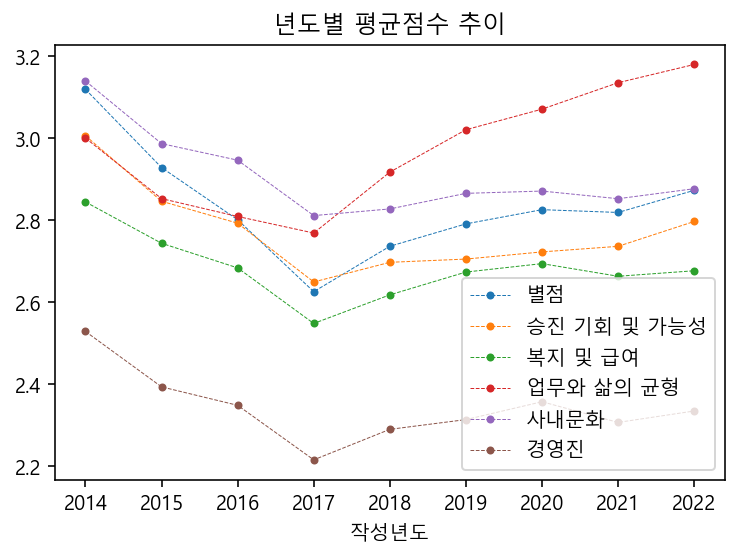

In [68]:
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--')
plt.title('년도별 평균점수 추이')
plt.show()

- IT vs 비 IT도 같은 경향인지 확인

In [69]:
cond = tmp['IT여부'] == 1
tmp_it = tmp[cond]
tmp_nit = tmp[~cond]

In [70]:
# it
grouped = tmp_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.116135,2.911412,2.811527,2.604427,2.749787,2.810828,2.832946,2.826350,2.839831
승진 기회 및 가능성,3.005357,2.839046,2.801842,2.638804,2.725362,2.748450,2.757151,2.767234,2.814831
복지 및 급여,2.838869,2.745098,2.689266,2.526254,2.619759,2.662379,2.682338,2.650214,2.647669
업무와 삶의 균형,3.015856,2.840739,2.825183,2.781493,2.948475,3.054789,3.098320,3.170334,3.215254
사내문화,3.134348,2.947524,2.927279,2.782906,2.831085,2.856085,2.860654,2.845227,2.833686
경영진,2.479966,2.332064,2.304065,2.151636,2.268562,2.290606,2.323650,2.277278,2.262500


In [71]:
# 비 it
grouped = tmp_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.122375,2.953401,2.785288,2.651950,2.717461,2.765294,2.815940,2.807919,2.911389
승진 기회 및 가능성,3.005431,2.856007,2.778661,2.661929,2.658988,2.650414,2.680885,2.694784,2.774004
복지 및 급여,2.852643,2.740283,2.674840,2.575446,2.614530,2.686408,2.707028,2.679228,2.710674
업무와 삶의 균형,2.972484,2.869920,2.785509,2.751134,2.874517,2.976771,3.036833,3.088013,3.135342
사내문화,3.146271,3.046599,2.971504,2.846386,2.821521,2.875920,2.882091,2.860494,2.927477
경영진,2.610065,2.488958,2.409764,2.297248,2.317655,2.341881,2.396486,2.344813,2.421093


- 전반적인 추제는 비슷한데
    - 비 IT직군의 경우 2017년에 최저치 이후 모든항목의 평점이 시간이 지날수록 꾸준하게 상승하고 있는 반면, 
    - IT직군의 경우 업무와 삶의 균형(워라밸) 외에는 다시 하락세를 보인다. 

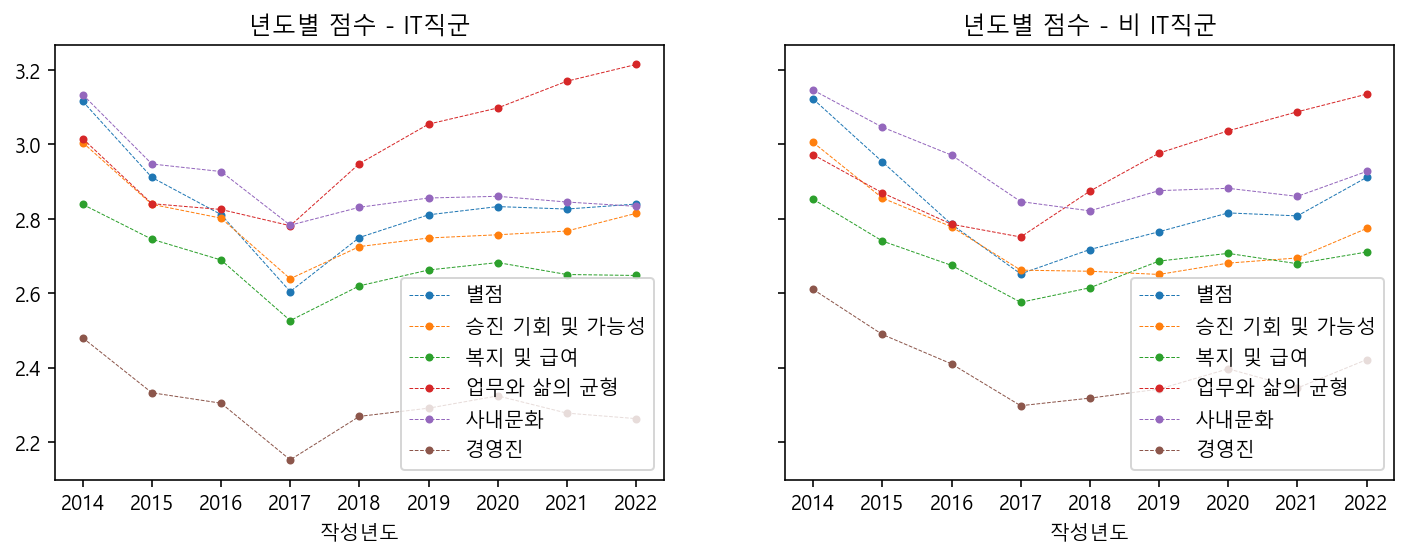

In [72]:
#시각화
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)

#it
grouped = tmp_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[0])
ax[0].set_title('년도별 점수 - IT직군')

#non-it
grouped = tmp_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[1])
ax[1].set_title('년도별 점수 - 비 IT직군')

plt.show()

### `1년 후 기업 전망`
- 성장 / 비슷 2가지 항목만 있다.
- 전체의 약 30%만이 1년뒤에 기업이 성장할 것이라고 작성   

In [73]:
cond = df['1년 후 기업 전망'] == 'unknown'
tmp = df[~cond]
tmp['1년 후 기업 전망'].unique()

array(['성장', '비슷'], dtype=object)

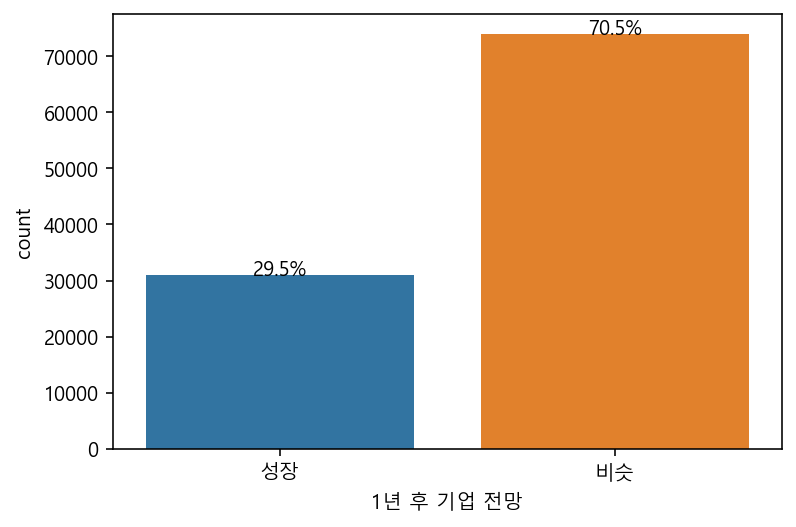

In [74]:
# 시각화
x = '1년 후 기업 전망'

g = sns.countplot(x=x, data=tmp)

total = float(len(tmp))

for p in g.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    g.annotate(percentage, (x-0.4, y),ha='center')
plt.show()

In [75]:
grouped = tmp[['1년 후 기업 전망'] + arr_scores].groupby('1년 후 기업 전망').mean()
grouped

,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진
1년 후 기업 전망,,,,,,
비슷,2.889371,2.789917,2.690394,3.038256,2.937435,2.381343
성장,3.893841,3.651293,3.559504,3.632035,3.799333,3.444186


- 1년 후 기업이 성장 할 것이다 라고 예상한 경우의 만족도가 그렇지 않은 그룹에 비해 만족도가 높다. 

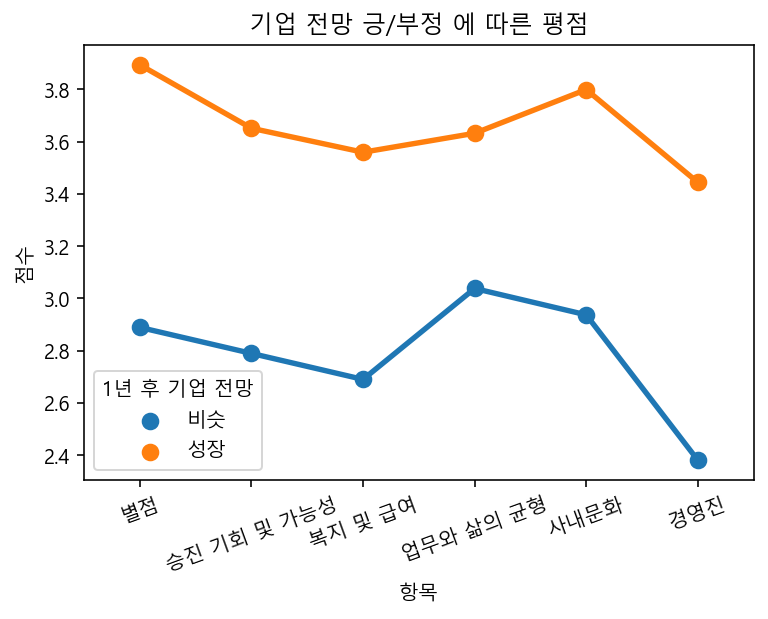

In [76]:
# 시각화
id_vars = ['1년 후 기업 전망']
value_vars = arr_scores

grouped = tmp[id_vars + value_vars].groupby('1년 후 기업 전망').mean().reset_index()
melted = grouped.melt(id_vars=id_vars, value_vars=value_vars, var_name='항목', value_name='점수')

x='항목'
y='점수'
sns.pointplot(y=y, x=x, data=melted, hue = '1년 후 기업 전망')
plt.xticks(rotation=20)
plt.title('기업 전망 긍/부정 에 따른 평점')

plt.show()

###  기업 추천여부
- 1년 후 기업 전망과 기업 추천여부는 매우 비슷한 항목인 것 같은데?
    - 기업을 추천한 경우가 전체의 49.2%로, 1년 후 기업이 성장할 것이다라고 응답한 경우보다 높은 비율을 보인다.
    - 1년 뒤에도 기업이 비슷할 것 같은데 추천한 경우가 상당 수 있다. 
        -> 어떤 경우?

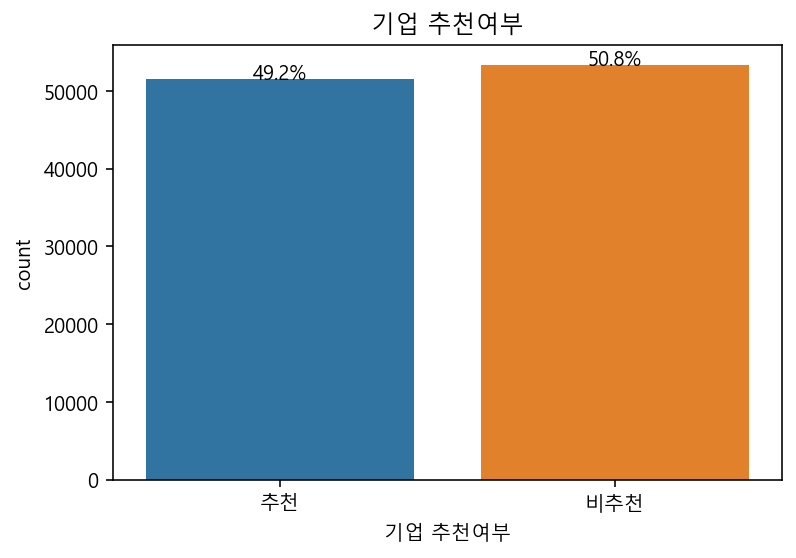

In [77]:
# 시각화
x = '기업 추천여부'

g = sns.countplot(x=x, data=tmp)

total = float(len(tmp))

for p in g.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    g.annotate(percentage, (x-0.4, y),ha='center')
plt.title('기업 추천여부')
plt.show()

- 기업 비추천한 경우 
    - 1년 후 기업전망을 긍정적으로 보는 경우는 매우 적다(약 10%). 
- 기업을 추천한 경우 
    - 성장할 것이라고 예측한 경우와, 반대의 경우가 거의 50:50으로 비슷하다.
    - 기업의 전망과 기업의 추천여부는 크게 상관이 없단 말인가?
    - **각각의 케이스(4가지)에 따라 텍스트 분석을 통해 원이에 대해 파악해보자**

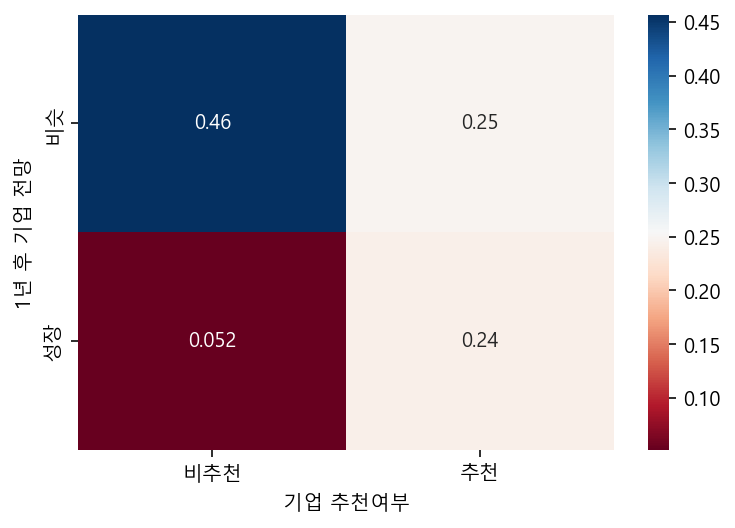

In [78]:
grouped = tmp[['1년 후 기업 전망', '기업 추천여부']].value_counts(['1년 후 기업 전망','기업 추천여부'])
grouped_ct = pd.crosstab(tmp['1년 후 기업 전망'], tmp['기업 추천여부'], normalize=True)
sns.heatmap(grouped_ct, annot=True, cmap='RdBu');

### 게시글 추천 수

In [79]:
df['게시글 추천 수'].describe()

count    148843.000000
mean          1.651841
std           4.170596
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         624.000000
Name: 게시글 추천 수, dtype: float64

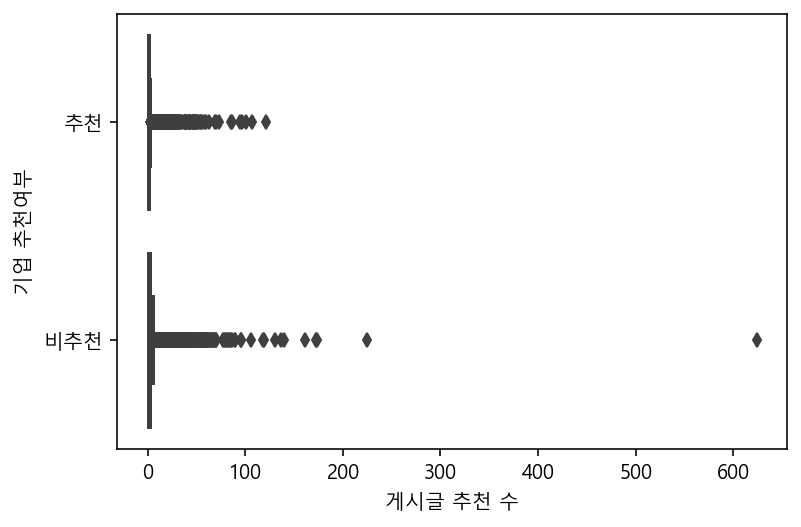

In [80]:
x='게시글 추천 수'
sns.boxplot(x=x, data=df, y='기업 추천여부');

- 추천 기능을 많이 사용하지 않는지 추천수 6개부터 이상치로 판단
- 이후 outlier 여부에 따른 텍스트 추가분석 필요 

In [81]:
Q1 = df['게시글 추천 수'].quantile(0.25)
Q3 = df['게시글 추천 수'].quantile(0.75)
IQR = Q3 - Q1

range1 = (Q1 - 1.5 *IQR)
range2 = (Q3 + 1.5 *IQR)

range1, range2

(-3.0, 5.0)

In [82]:
cond1 = df['게시글 추천 수'] < range1
cond2 = df['게시글 추천 수'] > range2

outlier = df[cond1 | cond2]
outlier

,회사명,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,...,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부,작성년도
index,,,,,,,,,,,,,,,,,,,,,
506,티몬,IT/인터넷,전직원,서울,2021. 01,2,2,2,4,4,...,대표 바뀌고 맛탱이감그전까지는 기업문화 좋고 다들 웃으며 열심히 으쌰으쌰하는어딜가도...,it쪽은 칼퇴. 영업부서만큼 강제야근강요나 실적강요 등은 없어서 나름 버텨볼만함.사...,걍 대표인민공화국.사람은 좋았다. 허나 2020년 기준 분위기가 살벌해져서 그것도 ...,대표님 퇴사하세요 그게 이 회사의 조금이나마 도움을 주고 가는 길입니다 물론 그럴 ...,unknown,비추천,7,1,수도권,2021
617,티몬,영업/제휴,현직원,서울,2020. 11,1,1,1,1,1,...,리뷰 공통되는 부분 있죠? 같이 일하는 동료들만 좋구요 나머지는 뭐 이딴 회사가 있...,1. 진짜 오늘 해야할 미션 완수하면 칼퇴 가능\n2. 같이 일하는 동료들이 젊고 ...,1. 100개 나열가능하지만 몇개만 적을게요 \n2. 일단 가장 바뀌어야 할 단 한...,반성하세요. 직원들이 행복해야 회사 살아나고 성장합니다. \n제발 직원 존중 좀 하...,unknown,비추천,7,0,수도권,2020
655,티몬,IT/인터넷,전직원,서울,2020. 09,1,1,1,2,2,...,2019년 현 대표 오기전까진 분위기 좋았음.\n현대표 이xx온 이후로 줄 퇴사 회...,기업의 장점이 다 없어져서 쓸말이 별로 없습니다\n같이 일하는 사람들은 좋습니다,적자 회사 인것은 알지만 이정도로 돈이 없나 싶음\n동호회 거의 없애는거나 마찬가지...,애정이 많은 회사였는데 안타깝습니다\n모든 직원들이 예민해져서 서로 싸우고 힘들어 ...,unknown,비추천,6,1,수도권,2020
711,티몬,서비스/고객지원,현직원,서울,2020. 08,1,1,1,1,1,...,별 하나 조차도 아깝다. 여기서 일하면서 자살 생각을 안 한 날이 단 하루도 없음,눈을 씻고 찾아 봐도 없다. 사람 취급을 전혀 못 받아서 놀랍고 굉장하다고 느낀다는...,"감옥에서도 화장실은 보내주더라. 콜센터 주제에 고객한테 전화 한 번 걸려면, 몇시간...",voc 보내면 적어도 답은 해줘라. 한달 지나서라도 답 오면 그나마 다행임. 대부분...,unknown,비추천,7,0,수도권,2020
748,티몬,디자인,전직원,서울,2020. 07,1,1,1,2,2,...,티몬은 현 대표가 있기 전과 후로 나뉘어집니다.사람들과 문화는 정말 좋아요.,윗사람 눈치 안보고 연차사용 가능사람들이 좋음문화가 좋음이전까지는 능력있는 사람들이...,복지가 다 사라짐대표가 새벽에 카톡으로 오더를 내리면 다음날 적용되어야 함 디자인실...,티몬 사람들이 하는 말 중에 하나라도 들어주세요 제발요!,unknown,비추천,7,0,수도권,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148813,트럼피아,unknown,현직원,unknown,unknown,1,1,2,3,1,...,별5 개짜리 기업평을 제외하고 이전 리뷰를 보면 이 회사를 잘 이해할수 있음,"다양한 복지제도, 액수는 케바케지만 분명히 존재하는 성과급","관리자, 기술력, 시간(일정) 개념의 부재\n성장가능성을 높이 볼수 없음",제발 일정 먼저 정해놓고 개발자한테 던져 놓지 맙시다,unknown,비추천,8,0,비수도권,unknown
148814,트럼피아,unknown,현직원,unknown,unknown,2,2,3,3,1,...,미국에서 서비스하는 20세기 대표 한국 IT 중소기업.,미국직원들과 함께 일하는 경험. 휴가를 편하게 사용할 수 있다. 대화가 거의 없는 ...,거의 대다수의 직원이 2년차가 안된다. 그로인해 의사결정이 오래 있던 사람의 의견을...,직원들의 불만을 듣지만 수용을 하는지는 미지수. 더이상 돈많이 벌수 있다는 것으로 ...,unknown,비추천,6,0,비수도권,unknown
148817,트럼피아,unknown,현직원,unknown,unknown,2,3,1,1,1,...,외국계 기업에 대한 환상이 무색하리만치 한국적이고 꼰대적인 기업,외국인과 일할 기회가 많다. 미국에서 몇개월간 근무할 기회가 주어지기도 한다.,하루 일하는 시간중 10분 쉬는것도 못마땅해함. 암묵적으로 초과근무에 대한 압박이 ...,정치질 하는 직원들한테 힘을 실어주는것을 그만두고 회사의 성장에 도움이 될만한 직원...,비슷,비추천,6,0,비수도권,unknown


In [83]:
norm = df[~(cond1 | cond2)]
norm

,회사명,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,...,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부,작성년도
index,,,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022. 04,3,5,5,5,5,...,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0,0,수도권,2022
1,티몬,영업/제휴,현직원,서울,2022. 04,3,5,5,5,1,...,"영업부서는 그나마 운영이 잘되나, 별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...",연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...,동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...,"신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...",비슷,추천,0,0,수도권,2022
2,티몬,디자인,현직원,서울,2022. 04,2,1,1,2,1,...,하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진,리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...,있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...,사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...,unknown,비추천,0,0,수도권,2022
3,티몬,영업/제휴,현직원,서울,2022. 04,3,4,3,4,4,...,개인적으로는 만족스럽습니다. 코로나 기간동안 재택도 꽤오래함.,"큰 인센티브는 없지만 연차 자유사용 및 업무 자유도가 높고, 나름 수평적인 기업문화임",뭔가 시도를 많이함..이커머스 특성상 그래야하는건 알지만 그래도 좀 부담스러움..,그냥 뭐..돈을 많이주면 좋을듯..그거말고 바라는거없음. 건물도 깔끔하고 좋음.,비슷,추천,0,0,수도권,2022
4,티몬,IT/인터넷,전직원,기타,2022. 04,3,3,3,3,3,...,무난히 다니기 좋은 회사입니다. 나쁘지 않습니다.,적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다.,힘든 점은 업무의 강도 및 시간적인 여유가 없을 때입니다.,워라벨과 균형이 조금씩 점진적으로 이루어졌으면 좋겠습니다.,비슷,추천,0,1,비수도권,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148846,한국옐로우페이지,unknown,현직원,unknown,unknown,1,2,2,2,3,...,"임원들이 정말 직원들 복지 아예 신경안쓰는 것 같아요,,\n직원들이 만족을 해야 회...","회식을 자주 하지만, 참가하지 않아도 별 말 없음.\n보너스가 다른 회사에 비하면 ...","단순보고가 많고, 회사의 효율성이 매우 떨어짐.\n임원들과의 대화가 잘 되지 않고,...",직원들 복지에 조금만 더 신경 써주시구요. 임원분들 진짜\n위에서만 그렇게 다 나눠...,비슷,비추천,0,0,비수도권,unknown
148847,한국옐로우페이지,unknown,현직원,unknown,unknown,2,3,2,3,5,...,정부의 지원을 받아 국내 중소기업의 홍보를 도와주는 회사정부지원에 대한 의존도가 높다.,국내의 다양한 중소기업을 만나볼 수 있다는 것과 업계 내에서는 인지도가 있는 편인 ...,직원들의 평균연령이 높고 늘 정체되어 있는 분위기. 가족회사라서 직원들이 암묵적으로...,누가봐도 불필요한 잉여인력은 회사 분위기를 저해시키는 요소입니다. 회사 성장에 해...,비슷,비추천,3,0,비수도권,unknown
148848,한국옐로우페이지,unknown,현직원,unknown,unknown,2,2,2,2,2,...,공공기관 아래에서 중소기업을 돕는 업무는 진행하는 회사,공공기관 및 협회 업무에 대해서 직간접적인 경험을 할 수 있음,"직원의 희생에 대해서 당연시하는 경향 있으며,그 때문에 퇴사가 많은 편",회사를 발전시키고 싶다면 우선 직원의 삶이 발전해야 한다는 것을 알아야 함,비슷,비추천,3,0,비수도권,unknown


- 비추천의 경우 게시글 추천 수가 상대적으로 많다.
    - 긍정적인 내용에 추천을 누르기 보단, 부정적인 내용에 추천을 더 많이 누른다고 봐야?


In [84]:
# 이상치 포함
df.groupby('기업 추천여부')['게시글 추천 수'].describe()

,count,mean,std,min,25%,50%,75%,max
기업 추천여부,,,,,,,,
비추천,94671.0,2.028625,4.768190,0.0,0.0,1.0,2.0,624.0
추천,54172.0,0.993373,2.716094,0.0,0.0,0.0,1.0,121.0


In [85]:
# 이상치 제거 후
norm.groupby('기업 추천여부')['게시글 추천 수'].describe()

,count,mean,std,min,25%,50%,75%,max
기업 추천여부,,,,,,,,
비추천,85174.0,1.015122,1.371196,0.0,0.0,0.0,2.0,5.0
추천,52445.0,0.665268,1.107046,0.0,0.0,0.0,1.0,5.0


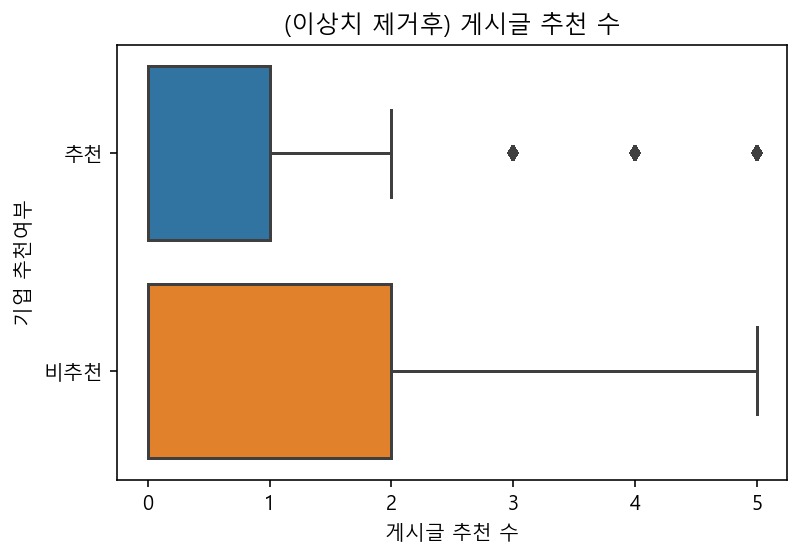

In [86]:
sns.boxplot(x='게시글 추천 수', data=norm,  y='기업 추천여부')
plt.title('(이상치 제거후) 게시글 추천 수');

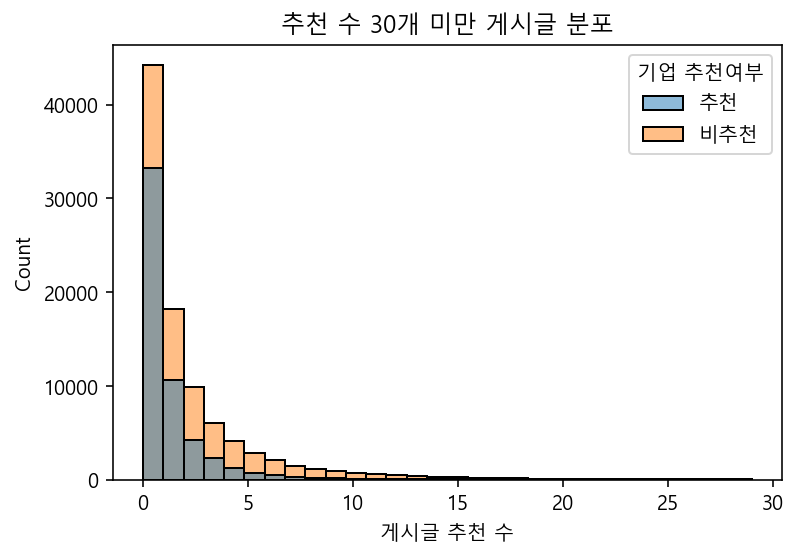

In [87]:
sns.histplot(x='게시글 추천 수', data=df[df['게시글 추천 수']<30], bins=30, hue='기업 추천여부')
plt.title('추천 수 30개 미만 게시글 분포');

## 리뷰 데이터(텍스트) 분석

### 전처리

In [88]:
# 전처리 함수
def clean_sentencese(text):
    pattern = '[\r|\n]'            # 개행문자 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))

    pattern = '<[^>]*>'            # html tag 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
                  
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+'    # 한글 자음, 모음 제거 
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = '[^\w\s]'            # 특수기호 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = re.compile(r'\s+')   # 이중 space 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    return text

In [89]:
# 전처리 실행
df['총평'] = df['총평'].map(clean_sentencese)
df['장점'] = df['장점'].map(clean_sentencese)
df['단점'] = df['단점'].map(clean_sentencese)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].map(clean_sentencese)

In [90]:
# 불용어 제거 함수
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = '것 수 사람이 너무 경우가 심함 좀 되는 한다 함 그 많음 안 대부분 경우 조금 하는 없는 더 대한 없고 없는 기업 다른 가능 다니기 것 비해 편 않음 따라 많이 업무 하지만 그래도 없음 있으며 또한 나름 회사가 또한 좋은 좋고 좋음 좋다 그리고 때문에 다 수 있는 할 일할 회사 다닐 수 있음 있다 매우 및 등 잘 있어 있어서 있고'
    stops = list(stops.split())
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [91]:
# 불용어 제거 실행
df['총평'] = df['총평'].map(remove_stopwords)
df['장점'] = df['장점'].map(remove_stopwords)
df['단점'] = df['단점'].map(remove_stopwords)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].map(remove_stopwords)

### TF
- mecab 쓰고 싶은데 윈도우에서는 mecab 안된다고 한다. 
- 첫 5문장 분석시 OKT보다 한나눔이 조금더 자연스럽게 명사가 끊어져서 한나눔으로 사용

In [92]:
tmp = df.copy()

#### 형태소 분석기 테스트 - 한나눔

In [93]:
hannanum=Hannanum()  
han_tmp = tmp['장점'][:5]
han_tmp

index
0                       사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1    연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2    리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...
3               큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                    적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
Name: 장점, dtype: object

In [99]:
han_tmp.apply(lambda x:hannanum.nouns(x))

index
0                            [카페, 안마, 사내, 복지, 칼퇴, 보장함]
1    [연차사용, 자유, 하반기, 시작, 전사, 리모트워크, 자율성, 극대화, 영업, 본...
2     [리모트워크, 준비, 중, 6월, 전사, 재택근무, 예정젊, 직원들, 팀바팀, 동료들]
3                    [인센티브, 연차, 자유사용, 자유도, 수평적, 기업문화임]
4                            [적당, 워라벨, 평균적, 급여, 시간, 나]
Name: 장점, dtype: object

#### 형태소 분석기 테스트 - Okt (구 트위터)

In [95]:
okt = Okt()
okt_tmp = tmp['장점'][:5]
okt_tmp

index
0                       사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1    연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2    리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...
3               큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                    적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
Name: 장점, dtype: object

In [98]:
okt_tmp.apply(lambda x:okt.nouns(x))

index
0                      [사내, 카페, 사내, 사내, 복지, 칼퇴, 보장, 함]
1    [연차, 사용, 자유, 하반기, 시작, 전사, 리, 모트, 워, 자율성, 대화, 영...
2         [리, 모트, 워, 준비, 중, 전사, 재택근무, 예정, 직원, 팀바팀, 동료]
3               [인센티브, 연차, 자유, 사용, 자유도, 수평, 기업, 문화, 임]
4                                  [워, 라벨, 평균, 급여, 시간]
Name: 장점, dtype: object

### 워드크라우드 시각화 

In [ ]:
%%time
arr_reviews = ['총평', '장점','단점','경영진에 바라는 점']
for col in arr_reviews:
    tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

In [ ]:
총평 = Counter(list(itertools.chain(*list(tmp['총평']))))
장점 = Counter(list(itertools.chain(*list(tmp['장점']))))
단점 = Counter(list(itertools.chain(*list(tmp['단점']))))
경영진 = Counter(list(itertools.chain(*list(tmp['경영진에 바라는 점']))))

# 정리

In [ ]:
wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='winter').generate_from_frequencies(장점)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# 고찰
- 형태소 분석기의 stemming 기능을 써서 조금더 자연스럽게 사용할 수 있겠다.
  - 형태소 분석기로 명사, 동사 먼저 추출한다음(시간도 오래 걸리고) 불용어 처리를 나중에 한다.
    - 지금은 전처리, 불용어 처리 먼저하고 바로 TF-IDF -> 모델 분석
    - 혹은 형태소 분석기까지 써서 장단점에 대한 워드 클라우드 분석
  - (참고:https://www.youtube.com/watch?v=R3jlcyehc50)

- PC - RAM 부족으로 전체에 대한 tf-idf 진행이 어려웠음
  - 이 경우 어떻게 문제를 해결하는지 확인하고, 해결법 찾아 학습 해볼 것
  - 분할해서 처리하고, 결과를 업데이트 해줘야 하는지?

- 보다 다양한 인사이트 발견을 위해서는, 다양한 소스에서 다양한 데이터들을 추가로 붙이고 처리하고 해야할 듯 하다. 